# Script Ajuste de caudales y pronóstico

## 1-Librerías

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import warnings
from scipy.stats import t

warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

## 2-Datos de entrada

In [53]:
# Indicar rutas de archivos de entrada y de salida
ruta_in= r'E:\9_Desarrollo\UDD\Analisis_de_Datos\Data\Inputs_Ajuste'
ruta_out = r'E:\9_Desarrollo\UDD\Analisis_de_Datos\Data\Outputs_Ajuste'

#Indicar fecha final a la que se desea proyectar
end_date = '2026-03-31'

In [6]:
def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load data from an Excel file.

    Args:
        file_path: Path to the Excel file.

    Returns:
        DataFrame containing the loaded data.
    """
    df = pd.read_excel(file_path, index_col=0)
    print(df)
    return df

In [7]:
file_path = r"E:\9_Desarrollo\UDD\Analisis_de_Datos\Data\Outputs_Suavizado\Q_Suavizado_Spline (Filtrado STL).xlsx"
df_input = load_excel_data(file_path)

              Fecha  Caudal (L/s)  Outlier  Caudal_Filtrado  \
Pozo                                                          
ARPES-01 2014-01-01      6.658555    False         6.658555   
ARPES-01 2014-02-01      7.717431    False         7.717431   
ARPES-01 2014-03-01      7.663063    False         7.663063   
ARPES-01 2014-04-01      7.573851    False         7.573851   
ARPES-01 2014-05-01      5.465879     True              NaN   
...             ...           ...      ...              ...   
XP17-05  2024-06-01      0.274481    False         0.274481   
XP17-05  2024-08-01      0.070146     True              NaN   
XP17-05  2024-09-01      0.100827     True              NaN   
XP17-05  2024-10-01      0.841751     True              NaN   
XP17-05  2024-12-01      0.211238    False         0.211238   

          Caudal_Filtrado_Suavizado  
Pozo                                 
ARPES-01                   6.991488  
ARPES-01                   7.218042  
ARPES-01                   7

In [10]:
df_input.head()

,Fecha,Caudal (L/s),Outlier,Caudal_Filtrado,Caudal_Filtrado_Suavizado
Pozo,,,,,
ARPES-01,2014-01-01,6.658555,False,6.658555,6.991488
ARPES-01,2014-02-01,7.717431,False,7.717431,7.218042
ARPES-01,2014-03-01,7.663063,False,7.663063,7.411679
ARPES-01,2014-04-01,7.573851,False,7.573851,7.574224
ARPES-01,2014-05-01,5.465879,True,NaN,NaN


In [8]:
'''# Cargar datos (seleccionar filtrado, suavizado y selección de tramo deseado)

Filtrado = 'Hampel'


Suavizado = 'Spline'
#Suavizado = 'STL'

Selc_Tramo = 'LastDecline'
#Selc_Tramo = 'maxPendLast'
#Selc_Tramo = 'maxPendLast2'

df_input = pd.read_excel(ruta_in + "/" + 'Q_Suavizado_' + Suavizado + ' (Filtrado ' + Filtrado + ').xlsx')


df_input.head()'''

'# Cargar datos (seleccionar filtrado, suavizado y selección de tramo deseado)\n\nFiltrado = \'Hampel\'\n\n\nSuavizado = \'Spline\'\n#Suavizado = \'STL\'\n\nSelc_Tramo = \'LastDecline\'\n#Selc_Tramo = \'maxPendLast\'\n#Selc_Tramo = \'maxPendLast2\'\n\ndf_input = pd.read_excel(ruta_in + "/" + \'Q_Suavizado_\' + Suavizado + \' (Filtrado \' + Filtrado + \').xlsx\')\n\n\ndf_input.head()'

In [11]:
df_input = df_input.reset_index()

# Tomar solo columnas de interes
dfFull = df_input[['Fecha', 'Pozo', 'Caudal_Filtrado_Suavizado']].copy()

# Renombrar columnas
dfFull = dfFull.rename(columns={'Caudal_Filtrado_Suavizado': 'Qs_l/s', 'Fecha': 'FechaMedicion'})

dfFull.head()

,FechaMedicion,Pozo,Qs_l/s
0,2014-01-01,ARPES-01,6.991488
1,2014-02-01,ARPES-01,7.218042
2,2014-03-01,ARPES-01,7.411679
3,2014-04-01,ARPES-01,7.574224
4,2014-05-01,ARPES-01,NaN


In [12]:
# Eliminación de valores NAN

# Obtener lista de pozos antes de eliminar volores NAN
pozo_before = set(dfFull['Pozo'].unique())

# Eliminar filas donde 'Qs_l/s' es NaN
dfFull = dfFull.dropna(subset=['Qs_l/s'])

# Obtener lista de pozos después de eliminar volores NAN
pozo_after = set(dfFull['Pozo'].unique())

# Revisar si un pozo completo fue eliminado
dropped_pozos = pozo_before - pozo_after
if dropped_pozos:
    print("Los siguientes pozos fueron eliminados:", dropped_pozos)
else:
    print("Ningún pozo fue eliminado.")

Ningún pozo fue eliminado.


In [13]:
#Número de pozos
pozosInteres = list(dfFull['Pozo'].unique())
len(pozosInteres)

447

In [14]:
#Se define el número mínimo de datos requeridos para hacer la estimación

numMinimoDatos = 1
numDatos = dfFull[dfFull['Pozo'].isin(pozosInteres)].groupby('Pozo')['Pozo'].count()
numDatos.sort_values()
pozosList = numDatos[numDatos>=numMinimoDatos].index
df = dfFull[dfFull['Pozo'].isin(pozosList)].copy()
df['Pozo'].nunique()

"""
# 'dfFull['Pozo'].isin(pozosInteres)' crea una boolean mask para las filas donde 'Pozo' está en 'pozosInteres', True donde están y False donde no.
# 'dfFull[dfFull['Pozo'].isin(pozosInteres)]' aplica la boolean mask a 'dfFull', resultando en un DataFrame que solo incluye las filas donde 'Pozo' está en 'pozosInteres'.
# '.groupby('Pozo')['Pozo'].count()' agrupa el nuevo DataFrame por 'Pozo' y cuenta el número de ocurrencias de cada valor de 'Pozo'.
# 'numDatos.sort_values()' ordena la Serie 'numDatos' en orden ascendente.
# 'numDatos[numDatos>=numMinimoDatos]' selecciona las filas de 'numDatos' donde el valor es mayor o igual a 'numMinimoDatos'
# '.index' obtiene los índices de estas filas, que en este caso son los valores únicos de 'Pozo'
# 'dfFull['Pozo'].isin(pozosList)' crea una boolean mask para las filas donde 'Pozo' está en 'pozosList'
# 'dfFull[dfFull['Pozo'].isin(pozosList)]' aplica la boolean mask a 'dfFull', resultando en un DataFrame que solo incluye las filas donde 'Pozo' está en 'pozosList'
# '.copy()' crea una copia del DataFrame resultante para evitar cualquier cambio en el DataFrame original 'dfFull'
# 'df['Pozo'].nunique()' calcula el número de valores únicos en la columna 'Pozo' de 'df'
"""

"\n# 'dfFull['Pozo'].isin(pozosInteres)' crea una boolean mask para las filas donde 'Pozo' está en 'pozosInteres', True donde están y False donde no.\n# 'dfFull[dfFull['Pozo'].isin(pozosInteres)]' aplica la boolean mask a 'dfFull', resultando en un DataFrame que solo incluye las filas donde 'Pozo' está en 'pozosInteres'.\n# '.groupby('Pozo')['Pozo'].count()' agrupa el nuevo DataFrame por 'Pozo' y cuenta el número de ocurrencias de cada valor de 'Pozo'.\n# 'numDatos.sort_values()' ordena la Serie 'numDatos' en orden ascendente.\n# 'numDatos[numDatos>=numMinimoDatos]' selecciona las filas de 'numDatos' donde el valor es mayor o igual a 'numMinimoDatos'\n# '.index' obtiene los índices de estas filas, que en este caso son los valores únicos de 'Pozo'\n# 'dfFull['Pozo'].isin(pozosList)' crea una boolean mask para las filas donde 'Pozo' está en 'pozosList'\n# 'dfFull[dfFull['Pozo'].isin(pozosList)]' aplica la boolean mask a 'dfFull', resultando en un DataFrame que solo incluye las filas dond

## 3-Detección de último dato desde el cual se declina

### 3.1-Metodología.
Se utiliza el último dato desde el cual declina para hacer el pronóstico

### Idea 1: 
- En una serie de n datos se define una vecindad de análisis rv_min y otra rv_max, con rv_min < rv_max < n.
- Para cada dato de la serie, se realiza una regresión lineal en una vencidad de rv_min datos hacia delante y otra de rv_min datos hacia atrás. Se reliza lo mismo con rv_max.  
- Tanto para rv_min como para rv_max se compara, para cada dato, las pendientes de la regresion hacia delante con la de hacia atrás, si son de distinto signo, o una es 0 y la otra no, se define el dato como cambios de tendencia. Se utilizan los siguiente criterios para identificar los cambios de tendencia:

  - SlopeDrch: pendiente de la regresión linean hacia delante para un dato k.
  - SlopeIzq: pendiente de la regresión linean hacia atrás para un dato k.

    - Si SlopeDrch*SlopeIzq < 0 ---> k es un cambio de tendencia
    - Si SlopeDrch*SlopeIzq > 0 ---> k no es un cambio de tendencia
    - Si SlopeDrch+SlopeIzq =!0 y SlopeDrch*SlopeIzq=0 --> k es un cambio de tendencia
    - Si SlopeDrch=SlopeIzq = 0 ---> k no es un cambio de tendencia
- Se guardan unicamente los cambios de tendencia que hayan sido identificados tanto para rv_min como para rv_max y que además cumplan que SlopeDrch < 0 (descendente).

- Se encuentra implementado en LastDecline(x)

### Idea 2: 
- Para cada dato $k$
    - Se realiza una regresión lineal de los últimos $k$ datos
    - Se determina el valor en el "extremo izquierdo" (el valor de la regresión en el dato $-k$)
- Se escoge el $k$ donde este "extremo izquierdo" es mas alto.

- Caso Patológico (por ejemplo pozo = 'PC-SW7-04'): Puede ser que el punto más alto tenga uno antes con menor valor (pero espaciado en el tiempo) que haga que la pendiente no varie mucho pero aumente el tiempo, alcanzando mayor valor. Para esto, se eliminan estos puntos si el indice siguiente tiene mayor valor.

- Se encuentra implementado en maxPendLast(x)

### Idea 3: 

- Unir idea 1 y 2.
- Se encuentra implementado en maxPendLast2(x)

### Nota: 
Recordar que si los datos son $(x_i,y_i)$ entonces la regresión lineal $y=\alpha x + \beta$ tiene 
como solución:
$$ \alpha = \frac{\sum_i (x_i-\bar{x})(y_i-\bar{y})}{\sum_i (x_i-\bar{x})^2} \qquad \beta = \bar{y} - \alpha \bar{x} $$

### 3.2-Automatización para todos los pozos

In [15]:
# Primera opción de selección de tramo

def LastDecline(x):
    #Rango de Vecindad
    rv_max = 12
    rv_min = 6

    T = (x['FechaMedicion']-x['FechaMedicion'].min()).dt.days.astype('float')

    #Columnas auxiliares
    x['PendIzq'] = 0.0
    x['PendDrch'] = 0.0
    x['Cambio signo 1'] = True
    x['Cambio signo 2'] = bool
    
    #Aplicar método de manera iterativa, primero para una vencindad de rv_min datos y luego para una de rv_max datos
    for v in [rv_min, rv_max]:
        
        #Regresión lineal para atrás y para delante
        for i in x.index[v:-v]:
            mediaParcialXIzq = T.loc[i-v:i].mean()
            mediaParcialXDrch = T.loc[i:i+v].mean()
            mediaParcialYIzq = x['Qs_l/s'].loc[i-v:i].mean()
            mediaParcialYDrch = x['Qs_l/s'].loc[i:i+v].mean()
            slopeIzq = ((T.loc[i-v:i]-mediaParcialXIzq)*(x['Qs_l/s'].loc[i-v:i]-mediaParcialYIzq)).sum()/(((T.loc[i-v:i]-mediaParcialXIzq)**2).sum() + 1e-12)
            slopeDrch = ((T.loc[i:i+v]-mediaParcialXDrch)*(x['Qs_l/s'].loc[i:i+v]-mediaParcialYDrch)).sum()/(((T.loc[i:i+v]-mediaParcialYDrch)**2).sum() + 1e-12)
            x.loc[i,'PendIzq'] = slopeIzq
            x.loc[i,'PendDrch'] = slopeDrch
        
        #Identificación de cambios de tendencia (ditingue entre pendientes: +, -, 0. No disntingue entre "acelaración" y "desacelaración")
        for i in x.index[:-2]:
            if np.isnan(x['PendIzq'][i]*x['PendDrch'][i]): #Identifica los valores NaN
                x.loc[i, 'Cambio signo 2']=False

            elif x['PendIzq'][i]+x['PendDrch'][i] != 0 and x['PendIzq'][i]*x['PendDrch'][i] == 0: #Identfica cuando una pendiente es cero y la otra distinta de cero.
                if x.loc[i, 'Cambio signo 1']==True and x['PendDrch'][i] < 0:
                    x.loc[i, 'Cambio signo 2']=True
                else:
                    x.loc[i, 'Cambio signo 2']=False

            elif x['PendIzq'][i]==x['PendDrch'][i] == 0: #Identifica cuando ambas pndientes son cero.
                x.loc[i, 'Cambio signo 2']=False

            elif x['PendIzq'][i]*x['PendDrch'][i] < 0: #Identifica cuando un pendiente es + y la otra -
                if x.loc[i, 'Cambio signo 1']==True and x['PendDrch'][i] < 0:
                    x.loc[i, 'Cambio signo 2']=True
                else:
                    x.loc[i, 'Cambio signo 2']=False
                    
            elif x['PendIzq'][i]*x['PendDrch'][i] > 0: #Identifica cuando ambas pendientes son del mismo signo.
                x.loc[i, 'Cambio signo 2']=False

        x['Cambio signo 1'] = x['Cambio signo 2']

        x['Cambio signo 2'].iloc[0] = True

        out = x[x['Cambio signo 2']==True]['FechaMedicion'].max()

    return out

In [16]:
# Segunda opción de selección de tramo
def maxPendLast(x):
    x=x.copy()
    valInitInterval = pd.Series(index=x.index)
    deltaEnd = (x['FechaMedicion']-x['FechaMedicion'].max()).dt.days
    for i in x.index[:-5]:
        mediaParcialX = deltaEnd.loc[i:].mean()
        mediaParcialY = x['Qs_l/s'].loc[i:].mean()
        epsilon = 1e-12  # small constant
        slope = ((deltaEnd.loc[i:]-mediaParcialX)*(x['Qs_l/s'].loc[i:]-mediaParcialY)).sum()/(((deltaEnd.loc[i:]-mediaParcialX)**2).sum() + epsilon)
        intercept = mediaParcialY - slope * mediaParcialX
        valInitInterval.loc[i] = intercept + slope * deltaEnd.loc[i]
    idxmax = valInitInterval.idxmax()
    while ((x.index.max() - idxmax) >= numMinimoDatos) and ((idxmax+1 in x.index) and (x.loc[idxmax+1]['Qs_l/s'] > x.loc[idxmax]['Qs_l/s'])):
        idxmax += 1

    return idxmax


In [17]:
# Tercera opción de selección de tramo

def maxPendLast2(x):
    x=x.copy()
    valInitInterval = pd.Series(index=x.index)
    deltaEnd = (x['FechaMedicion']-x['FechaMedicion'].max()).dt.days
    for i in x.index[:-5]:
        mediaParcialX = deltaEnd.loc[i:].mean()
        mediaParcialY = x['Qs_l/s'].loc[i:].mean()
        epsilon = 1e-12  # small constant
        slope = ((deltaEnd.loc[i:]-mediaParcialX)*(x['Qs_l/s'].loc[i:]-mediaParcialY)).sum()/(((deltaEnd.loc[i:]-mediaParcialX)**2).sum() + epsilon)
        intercept = mediaParcialY - slope * mediaParcialX
        valInitInterval.loc[i] = intercept + slope * deltaEnd.loc[i]
    idxmax = valInitInterval.idxmax()
    while ((x.index.max() - idxmax) >= numMinimoDatos) and ((idxmax+1 in x.index) and (x.loc[idxmax+1]['Qs_l/s'] > x.loc[idxmax]['Qs_l/s'])):
        idxmax += 1
        
    T = (x['FechaMedicion']-x['FechaMedicion'].min()).dt.days.astype('float')
    for i in x.index[:]:
        x.loc[i, 'Tiempo'] = T[i]

    v = 7
    x['PendIzq'] = 0.0
    x['PendDrch'] = 0.0
    x['Cambio de tendencia 1'] = False

    trend_changes = []  # List to store points where the trend changes
    for i in x.index[v:-v]:
        mediaParcialXIzq = x['Tiempo'].loc[i-v:i].mean()
        mediaParcialXDrch = x['Tiempo'].loc[i:i+v].mean()
        mediaParcialYIzq = x['Qs_l/s'].loc[i-v:i].mean()
        mediaParcialYDrch = x['Qs_l/s'].loc[i:i+v].mean()
        slopeIzq = ((x['Tiempo'].loc[i-v:i]-mediaParcialXIzq)*(x['Qs_l/s'].loc[i-v:i]-mediaParcialYIzq)).sum()/(((x['Tiempo'].loc[i-v:i]-mediaParcialXIzq)**2).sum() + epsilon)
        slopeDrch = ((x['Tiempo'].loc[i:i+v]-mediaParcialXDrch)*(x['Qs_l/s'].loc[i:i+v]-mediaParcialYDrch)).sum()/(((x['Tiempo'].loc[i:i+v]-mediaParcialXDrch)**2).sum() + epsilon)
        x.loc[i,'PendIzq'] = slopeIzq
        x.loc[i,'PendDrch'] = slopeDrch

        if np.isnan(x['PendIzq'][i]*x['PendDrch'][i]): 
            x.loc[i, 'Cambio de tendencia 1'] = False

        elif x['PendIzq'][i]+x['PendDrch'][i] != 0 and x['PendIzq'][i]*x['PendDrch'][i] == 0:
            x.loc[i, 'Cambio de tendencia 1'] = True

        elif x['PendIzq'][i] == x['PendDrch'][i] == 0: 
            x.loc[i, 'Cambio de tendencia 1'] = False

        elif x['PendIzq'][i]*x['PendDrch'][i] < 0:
            x.loc[i, 'Cambio de tendencia 1'] = True
            
        elif x['PendIzq'][i]*x['PendDrch'][i] > 0: 
            x.loc[i, 'Cambio de tendencia 1'] = False

        if x.loc[i, 'Cambio de tendencia 1'] == True and i > idxmax:
            idxmax = i
            trend_changes.append(i)  # Append index to the list            
                
    return idxmax, trend_changes

In [18]:
# Aplicar función de selección de tramo (según selección inicial del usuario)

Last_Decline=pd.DataFrame()
if Selc_Tramo =="LastDecline":
    Last_Decline = df.groupby('Pozo').apply(LastDecline).reset_index()
    Last_Decline = Last_Decline.set_axis(labels=['Pozo','DateDecline'], axis=1)
    
    print("Selección de tramo: LastDecline")

elif Selc_Tramo =="maxPendLast":
    Last_Decline = df.groupby('Pozo').apply(maxPendLast).reset_index()
    Last_Decline = Last_Decline.set_axis(labels=['Pozo','IdxMax'], axis=1)
    Last_Decline['DateDecline'] = pd.Series(df.loc[Last_Decline['IdxMax']]['FechaMedicion']).set_axis(Last_Decline.index)
    Last_Decline = Last_Decline.drop(columns=['IdxMax'])

    print("Selección de tramo: maxPendLas")

elif Selc_Tramo =="maxPendLast2":
    Last_Decline = df.groupby('Pozo').apply(maxPendLast2).reset_index()
    Last_Decline = Last_Decline.set_axis(labels=['Pozo','MaxPendLast2'], axis=1)

    # Separar la tupla en dos columnas
    Last_Decline[['IdxMax', 'TrendChanges']] = pd.DataFrame(Last_Decline['MaxPendLast2'].tolist(), index=Last_Decline.index)

    Last_Decline['DateDecline'] = pd.Series(df.loc[Last_Decline['IdxMax']]['FechaMedicion']).set_axis(Last_Decline.index)

    # Eliminar columnas 'MaxPendLast', 'TrendChanges' y 'IdxMax'
    Last_Decline = Last_Decline.drop(columns=['MaxPendLast2'])
    Last_Decline = Last_Decline.drop(columns=['TrendChanges'])
    Last_Decline = Last_Decline.drop(columns=['IdxMax'])

    print("Selección de tramo: maxPendLas2")
 
Last_Decline

Selección de tramo: LastDecline


,Pozo,DateDecline
0,ARPES-01,2015-01-01
1,ARPES-03,2022-05-01
2,BCX-005,2024-02-01
3,BCX-023,2023-07-01
4,CX-060S,2020-07-01
...,...,...
442,X-408,2023-10-01
443,XP-0268R,2023-07-01
444,XP-0284,2020-05-01
445,XP17-03,2022-05-01


### 3.2-Graficar algunos ejemplos

In [19]:
#Seleccionar un grupo de pozos para graficar

pozosToPlot = ['ARPES-01', 'ARPES-03', 'BCX-005', 'BCX-023', 'CX-060S', 'CX-072', 'CX-084', 'CX-085', 'CX-089', 'CX-090S', 'CX-097P', 'CX-098P']

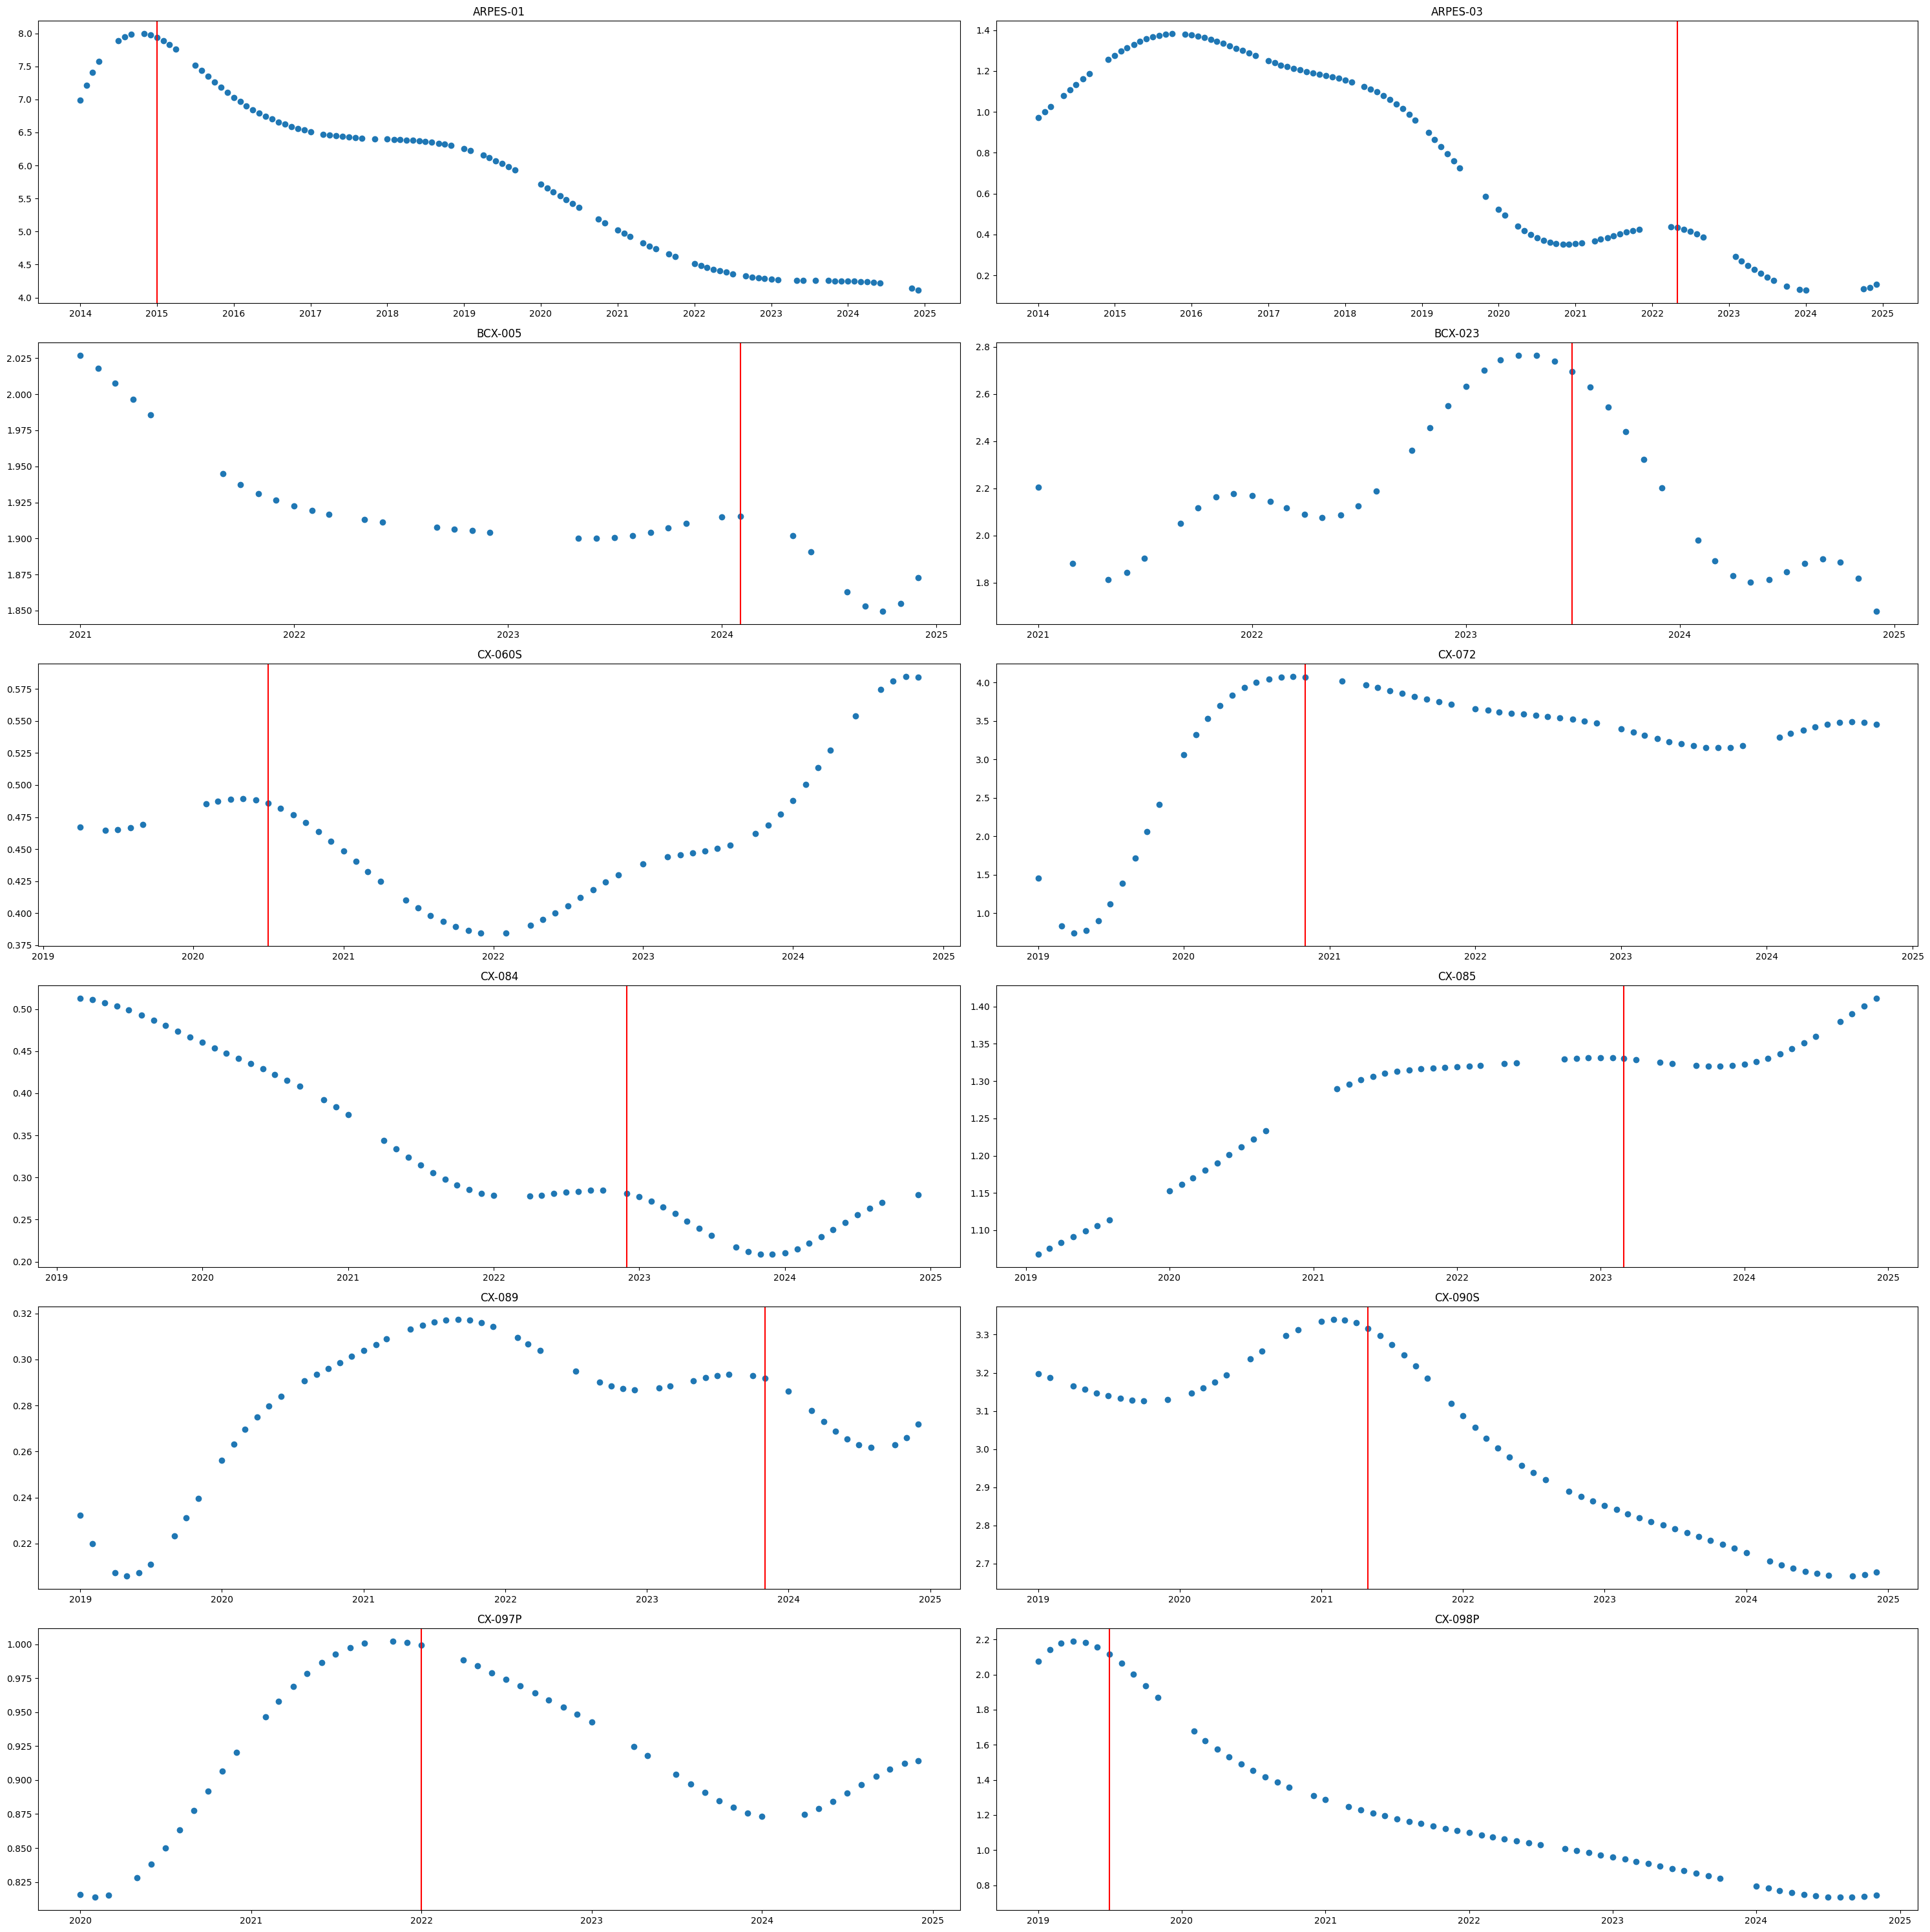

In [20]:
# Filter the DataFrame
df_filtered = df[df['Pozo'].isin(pozosToPlot)]
LastDecline_filtered = Last_Decline[Last_Decline['Pozo'].isin(pozosToPlot)]

# Create a figure and a set of subplots with 2 rows and 6 columns
fig, axs = plt.subplots(6, 2, figsize=(30, 30))  # Adjust the figure size as needed

# Flatten the array of axes
axs = axs.flatten()

# Iterate over each subplot and plot the data
for ax, pozo in zip(axs, pozosToPlot):
    # Filter the data for the current 'Pozo'
    df_pozo = df_filtered[df_filtered['Pozo'] == pozo]
    LastDecline_pozo = LastDecline_filtered[LastDecline_filtered['Pozo'] == pozo]

    # Plot the points
    ax.scatter(df_pozo['FechaMedicion'], df_pozo['Qs_l/s'])

    # Plot the vertical lines
    for date in LastDecline_pozo['DateDecline']:
        ax.axvline(x=date, color='red')

    # Set the title
    ax.set_title(pozo)

    # Set the x-axis to display dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Display the plot
plt.show()

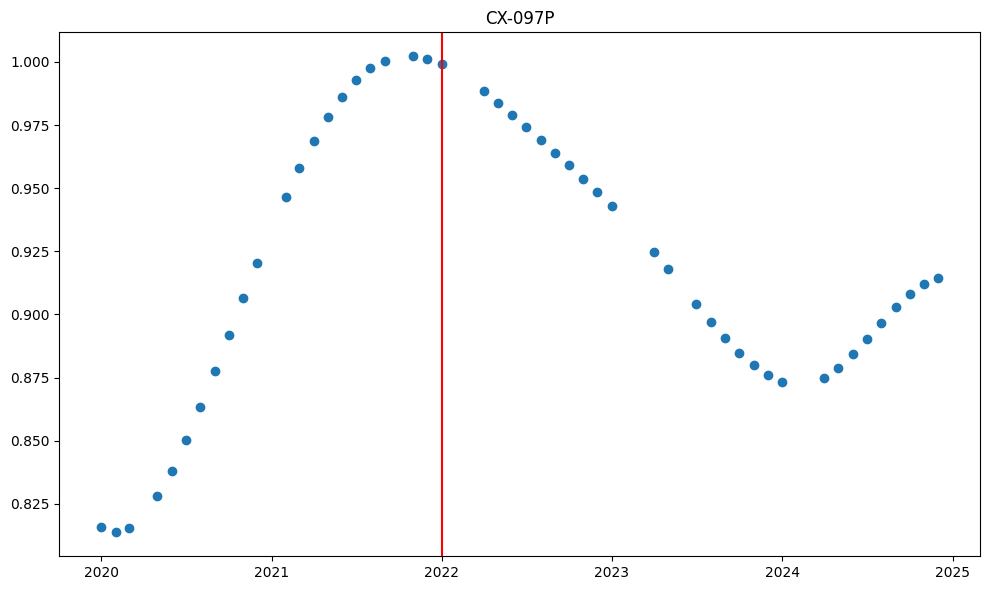

In [21]:
#Seleccionar un único pozo para graficar
# Filter the DataFrame
toPlot='CX-097P'
df_filtered = df[df['Pozo'] == toPlot]
LastDecline_filtered = Last_Decline[Last_Decline['Pozo'] == toPlot]

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the points
ax.scatter(df_filtered['FechaMedicion'], df_filtered['Qs_l/s'])

# Plot the vertical lines
for date in LastDecline_filtered['DateDecline']:
    ax.axvline(x=date, color='red')

# Set the title
ax.set_title(toPlot)

# Set the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Display the plot
plt.show()

## 4-Ajuste

### 4.1-Método

Para la regresión con Decline hiperbólico se asume que el caudal se mueve en el tiempo de acuerdo a la ecuación
$$ q(t) = \frac{q^0}{(1+b\cdot d^0\cdot t)^{1/b}}$$
donde $q^0$ es un caudal inicial ($t=0$), $d^0$ es un decline inicial ($t=0$) y $b$ es un parámetro entre 0 y 1.

Para estimar esto, se realiza lo siguiente (basado en _Towler and Bansal (1993)_ https://doi.org/10.1016/0920-4105(93)90003-W

- Se define un valor que se asume constante $\gamma = b\cdot d^0$. 
- Se transforma
$$ q(t) = \frac{q^0}{(1+\gamma\cdot t)^{1/b}}$$
aplicando logaritmo en 
$$ \log(q(t)) = \log(q^0) -\frac {1}{b}\log(1+\gamma\cdot t)$$
- Se aplica una regresión lineal simple $y=\alpha x + \beta$ a los datos $(x_i,y_i) = (\log(1+\gamma\cdot t_i),\log(q_i))$
- Luego: 
    - $q^0 = \exp(\beta)$
    - $b = -1/\alpha$
    - $d^0 = \gamma/b$
- Se repito esto con distintos valores de $\gamma$ y se escoge el que tenga un error SSE menor.

En el caso de los métodos Exponencial y Custodio se realiza el mismo procedimento, con diferencias menores. En cuanto al método constante, en este unicamente se calcula el promedio de los datos reales.

### 4.2-Aplicar Ajustes

Se definen las funciones para ajustar los distintos modelos

In [22]:
# Colocar columa 'Pozo' como índice del df Last_Decline
Last_Decline = Last_Decline.set_index('Pozo')

In [23]:
# Pendiente para regresión lineal simple
def calcular_pendiente(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    b_numerator = np.sum((x - x_mean) * (y - y_mean))
    b_denominator = np.sum((x - x_mean)**2)
    b = b_numerator / b_denominator
    return b

In [24]:
# Función para ajuste de modelo Exponencial
def estimatorEXP(x):
    pozo = x['Pozo'].max()
    fechabase =  Last_Decline.loc[pozo,'DateDecline']
    fechabase_full = x['FechaMedicion'].min()
    idx = ((x['Qs_l/s']>0) & (x['FechaMedicion']>=fechabase))
    idx_full = ((x['Qs_l/s']>0))
    caudal = x.loc[idx,'Qs_l/s']
    caudal_full = x.loc[idx_full,'Qs_l/s']
    t = x.loc[idx,'FechaMedicion'].copy().apply(lambda x: (x- fechabase).days)
    t_full = x.loc[idx_full,'FechaMedicion'].copy().apply(lambda x: (x- fechabase_full).days)
    logQ = np.log(caudal)
    slope = (((t - t.mean())*(logQ-logQ.mean())).sum())/(((t - t.mean())**2).sum())
    intercept = logQ.mean() - slope*t.mean()
    d = -slope
    q = np.exp(intercept)
    estim = q * np.exp(-d*t)
    if (d < 0):
        return None
    R2=[1-(((estim-caudal)**2).sum())/(((caudal-caudal.mean())**2).sum())]
    m=calcular_pendiente(t_full,caudal_full)
    res = pd.DataFrame({
        'gamma' : [np.nan],
        'b' : [0],
        'd' : [d],
        'q' : [q],
        'delta' : [np.nan],
        'tau' : [np.nan],
        'R2real' : R2,
        'R2internal' : [1-(((intercept+slope*t-logQ)**2).sum()/((logQ-logQ.mean())**2).sum())],
        'm': m,
        'FechaDecline' : [fechabase]
    }, index=['Exponential'])
    res.index.name = 'Method'
    return res

In [25]:
# Función para ajuste de modelo Hiperbólico
def estimatorHyper(x):
    pozo = x['Pozo'].max()
    fechabase =  Last_Decline.loc[pozo,'DateDecline']
    fechabase_full = x['FechaMedicion'].min()
    idx = ((x['Qs_l/s']>0) & (x['FechaMedicion']>=fechabase))
    idx_full = ((x['Qs_l/s']>0))
    caudal = x.loc[idx,'Qs_l/s']
    caudal_full = x.loc[idx_full,'Qs_l/s']
    t = x.loc[idx,'FechaMedicion'].copy().apply(lambda x: (x- fechabase).days)
    t_full = x.loc[idx_full,'FechaMedicion'].copy().apply(lambda x: (x- fechabase_full).days)
    logQ = np.log(caudal)
    
    inRes = pd.DataFrame(columns=['gamma','b','d','q','delta','tau','R2real','R2internal','m', 'FechaDecline'])
    for nDi in np.logspace(-10,0, num=50):
        dumm = np.log(1+nDi*t)
        slope = (((dumm - dumm.mean())*(logQ-logQ.mean())).sum())/(((dumm - dumm.mean())**2).sum())
        intercept = logQ.mean() - slope*dumm.mean()
        b = -1/slope
        d = nDi/b
        q = np.exp(intercept)
        delta = np.nan
        tau = np.nan
        estim = q / ((1+d*b*t)**(1/b))
        r2 = 1-(((estim-caudal)**2).sum())/(((caudal-caudal.mean())**2).sum())
        r2int = 1-(((intercept+slope*dumm-logQ)**2).sum())/(((logQ-logQ.mean())**2).sum())
        m=calcular_pendiente(t_full, caudal_full)
        inRes.loc[len(inRes)] = (nDi,b,d,q,delta,tau,r2,r2int,m,fechabase)

    if (inRes['b']>=0).sum() == 0: 
        return None

    out = inRes[(inRes['b']>=0)].sort_values('R2real', ascending=False).head(1)
    out.index = ['Hyperbolic']
    out.index.name = 'Method'
    return out


In [26]:
# Función para ajuste de modelo Constante
def estimatorConstant(x):
    pozo = x['Pozo'].max()
    fechabase =  Last_Decline.loc[pozo,'DateDecline']
    fechabase_full = x['FechaMedicion'].min()
    idx = ((x['Qs_l/s']>0) & (x['FechaMedicion']>=fechabase))
    idx_full = ((x['Qs_l/s']>0))
    caudal = x.loc[idx,'Qs_l/s']
    caudal_full = x.loc[idx_full,'Qs_l/s']
    t_full = x.loc[idx_full,'FechaMedicion'].copy().apply(lambda x: (x- fechabase_full).days)
    m=calcular_pendiente(t_full, caudal_full)
    res = pd.DataFrame({
        'gamma' : [np.nan],
        'b' : [np.nan],
        'd' : 0,
        'q' : caudal.mean(),
        'delta' : [np.nan],
        'tau' : [np.nan],
        'R2real' : 0,
        'R2internal' : 0,
        'm' : m,
        'FechaDecline' : [fechabase]
    }, index=['Constant'])
    res.index.name = 'Method'
    return res

In [27]:
# Función para ajuste de modelo Custodio
def estimatorCustodio(x):
    pozo = x['Pozo'].max()
    fechabase =  Last_Decline.loc[pozo,'DateDecline']
    fechabase_full = x['FechaMedicion'].min()
    idx = ((x['Qs_l/s']>0) & (x['FechaMedicion']>=fechabase))
    idx_full = ((x['Qs_l/s']>0))
    caudal = x.loc[idx,'Qs_l/s']
    caudal_full = x.loc[idx_full,'Qs_l/s']
    t = x.loc[idx,'FechaMedicion'].copy().apply(lambda x: (x- fechabase).days)
    t_full = x.loc[idx_full,'FechaMedicion'].copy().apply(lambda x: (x- fechabase_full).days)
    qmin = caudal.min() - 1/1000000
    
    inRes = pd.DataFrame(columns=['gamma','b','d','q','delta','tau','R2real','R2internal', 'm','FechaDecline'])
    for q in np.linspace(0.1,qmin, num=50):
        logQ = np.log(caudal-q)
        slope = (((t - t.mean())*(logQ-logQ.mean())).sum())/(((t - t.mean())**2).sum())
        intercept = logQ.mean() - slope*t.mean()
        nDi = np.nan
        b = np.nan
        d = np.nan
        delta = np.exp(intercept)/q
        tau = -1/slope
        estim = q*(1+delta*np.exp(-t/tau))
        r2 = 1-(((estim-caudal)**2).sum())/(((caudal-caudal.mean())**2).sum())
        r2int = 1-(((intercept+slope*t-logQ)**2).sum())/(((logQ-logQ.mean())**2).sum())
        m=calcular_pendiente(t_full, caudal_full)   ###
        inRes.loc[len(inRes)] = (nDi,b,d,q,delta,tau,r2,r2int,m,fechabase) ###
    if (inRes['tau']>=0).sum() == 0: 
        return None
    out = inRes[(inRes['tau']>=0)].sort_values('R2real', ascending=False).head(1)
    out.index = ['Custodio']
    out.index.name = 'Method'
    return out

In [28]:
# Aplicar funciones de ajuste de cada modelo para cada pozo y guardar parámetros resultantes en un df
resultsDecline = df.groupby('Pozo').apply(estimatorEXP)
resultsDecline = pd.concat([resultsDecline, df.groupby('Pozo').apply(estimatorHyper)])
resultsDecline = pd.concat([resultsDecline, df.groupby('Pozo').apply(estimatorCustodio)])
resultsDecline = pd.concat([resultsDecline, df.groupby('Pozo').apply(estimatorConstant)])

resultsDecline

,,gamma,b,d,q,delta,tau,R2real,R2internal,m,FechaDecline
Pozo,Method,,,,,,,,,,
ARPES-01,Exponential,NaN,0.0,0.000189,7.731308,NaN,NaN,0.963763,0.963776,-0.001042,2015-01-01
ARPES-03,Exponential,NaN,0.0,0.001381,0.399445,NaN,NaN,0.892902,0.825555,-0.000367,2022-05-01
BCX-005,Exponential,NaN,0.0,0.000109,1.911980,NaN,NaN,0.729746,0.724907,-0.000084,2024-02-01
BCX-023,Exponential,NaN,0.0,0.000833,2.549091,NaN,NaN,0.851341,0.828683,-0.000066,2023-07-01
CX-072,Exponential,NaN,0.0,0.000138,3.894982,NaN,NaN,0.659561,0.626381,0.000669,2020-11-01
...,...,...,...,...,...,...,...,...,...,...,...
X-408,Constant,NaN,NaN,0.000000,1.976169,NaN,NaN,0.000000,0.000000,-0.004553,2023-10-01
XP-0268R,Constant,NaN,NaN,0.000000,1.763272,NaN,NaN,0.000000,0.000000,-0.000736,2023-07-01
XP-0284,Constant,NaN,NaN,0.000000,1.137162,NaN,NaN,0.000000,0.000000,0.000042,2020-05-01


## 5-Pronóstico

Se realizan proyecciones futuras con cada uno de los modelos para cada pozo

In [29]:
# Colocar columa 'Method' como índice del df resultsDecline
resultsDecline = resultsDecline.reset_index().set_index('Method')
resultsDecline

,Pozo,gamma,b,d,q,delta,tau,R2real,R2internal,m,FechaDecline
Method,,,,,,,,,,,
Exponential,ARPES-01,NaN,0.0,0.000189,7.731308,NaN,NaN,0.963763,0.963776,-0.001042,2015-01-01
Exponential,ARPES-03,NaN,0.0,0.001381,0.399445,NaN,NaN,0.892902,0.825555,-0.000367,2022-05-01
Exponential,BCX-005,NaN,0.0,0.000109,1.911980,NaN,NaN,0.729746,0.724907,-0.000084,2024-02-01
Exponential,BCX-023,NaN,0.0,0.000833,2.549091,NaN,NaN,0.851341,0.828683,-0.000066,2023-07-01
Exponential,CX-072,NaN,0.0,0.000138,3.894982,NaN,NaN,0.659561,0.626381,0.000669,2020-11-01
...,...,...,...,...,...,...,...,...,...,...,...
Constant,X-408,NaN,NaN,0.000000,1.976169,NaN,NaN,0.000000,0.000000,-0.004553,2023-10-01
Constant,XP-0268R,NaN,NaN,0.000000,1.763272,NaN,NaN,0.000000,0.000000,-0.000736,2023-07-01
Constant,XP-0284,NaN,NaN,0.000000,1.137162,NaN,NaN,0.000000,0.000000,0.000042,2020-05-01


In [30]:
# Lista de pozos ajustados
pozosList = list(resultsDecline['Pozo'].unique())

In [31]:
#Generar prónstico con todo los métodos para todos los pozos

resultsForecast = pd.DataFrame(columns=['Pozo','Fecha','Forecast-Hyperbolic','Forecast-Exponential','Forecast-Custodio','Forecast-Constant'])

for pozo in pozosList:
    time = pd.date_range(Last_Decline.loc[pozo,'DateDecline'], end=pd.Timestamp(end_date), freq='MS')
    days = (time - Last_Decline.loc[pozo,'DateDecline']).days
    forecast = np.empty(len(time))
    forecast[:]=np.nan
    forecast1 = forecast
    forecast2 = forecast
    forecast3 = forecast
    forecast4 = forecast
    for row in resultsDecline[resultsDecline['Pozo']==pozo].iterrows():
        if row[0]=='Hyperbolic':
            forecast1 = row[1]['q']/((1+row[1]['b']*row[1]['d']*days)**(1/row[1]['b']))
        elif row[0]=='Exponential':
            forecast2 = row[1]['q']*np.exp(-row[1]['d']*days)
        elif row[0]=='Custodio':
            forecast3 = row[1]['q']*(1+row[1]['delta']*np.exp(-days/row[1]['tau']))
        elif row[0]=='Constant':
            forecast4 = np.ones(len(days))*row[1]['q']
        else:
            print("Warning: No method for pozo " + str(pozo))

    forecastDf= pd.DataFrame({'Pozo': pozo, 'Fecha': time, 'Forecast-Hyperbolic': forecast1,'Forecast-Exponential': forecast2,
    'Forecast-Custodio': forecast3,'Forecast-Constant': forecast4})

    resultsForecast = pd.concat([resultsForecast, forecastDf], axis=0)
resultsForecast

,Pozo,Fecha,Forecast-Hyperbolic,Forecast-Exponential,Forecast-Custodio,Forecast-Constant
0,ARPES-01,2015-01-01,7.731308,7.731308,7.736220,5.709163
1,ARPES-01,2015-02-01,7.686155,7.686155,7.690791,5.709163
2,ARPES-01,2015-03-01,7.645598,7.645598,7.649990,5.709163
3,ARPES-01,2015-04-01,7.600945,7.600945,7.605074,5.709163
4,ARPES-01,2015-05-01,7.557981,7.557981,7.561861,5.709163
...,...,...,...,...,...,...
50,W-UC-14,2025-11-01,NaN,NaN,NaN,2.277604
51,W-UC-14,2025-12-01,NaN,NaN,NaN,2.277604
52,W-UC-14,2026-01-01,NaN,NaN,NaN,2.277604
53,W-UC-14,2026-02-01,NaN,NaN,NaN,2.277604


### 5.1-Graficar Pronóstico

In [32]:
#Seleccionar un grupo de pozos para graficar
pozosToPlot = ['ARPES-01', 'ARPES-03', 'BCX-005', 'BCX-023', 'CX-060S', 'CX-072', 'CX-084', 'CX-085', 'CX-089', 'CX-090S', 'CX-097P', 'CX-098P']

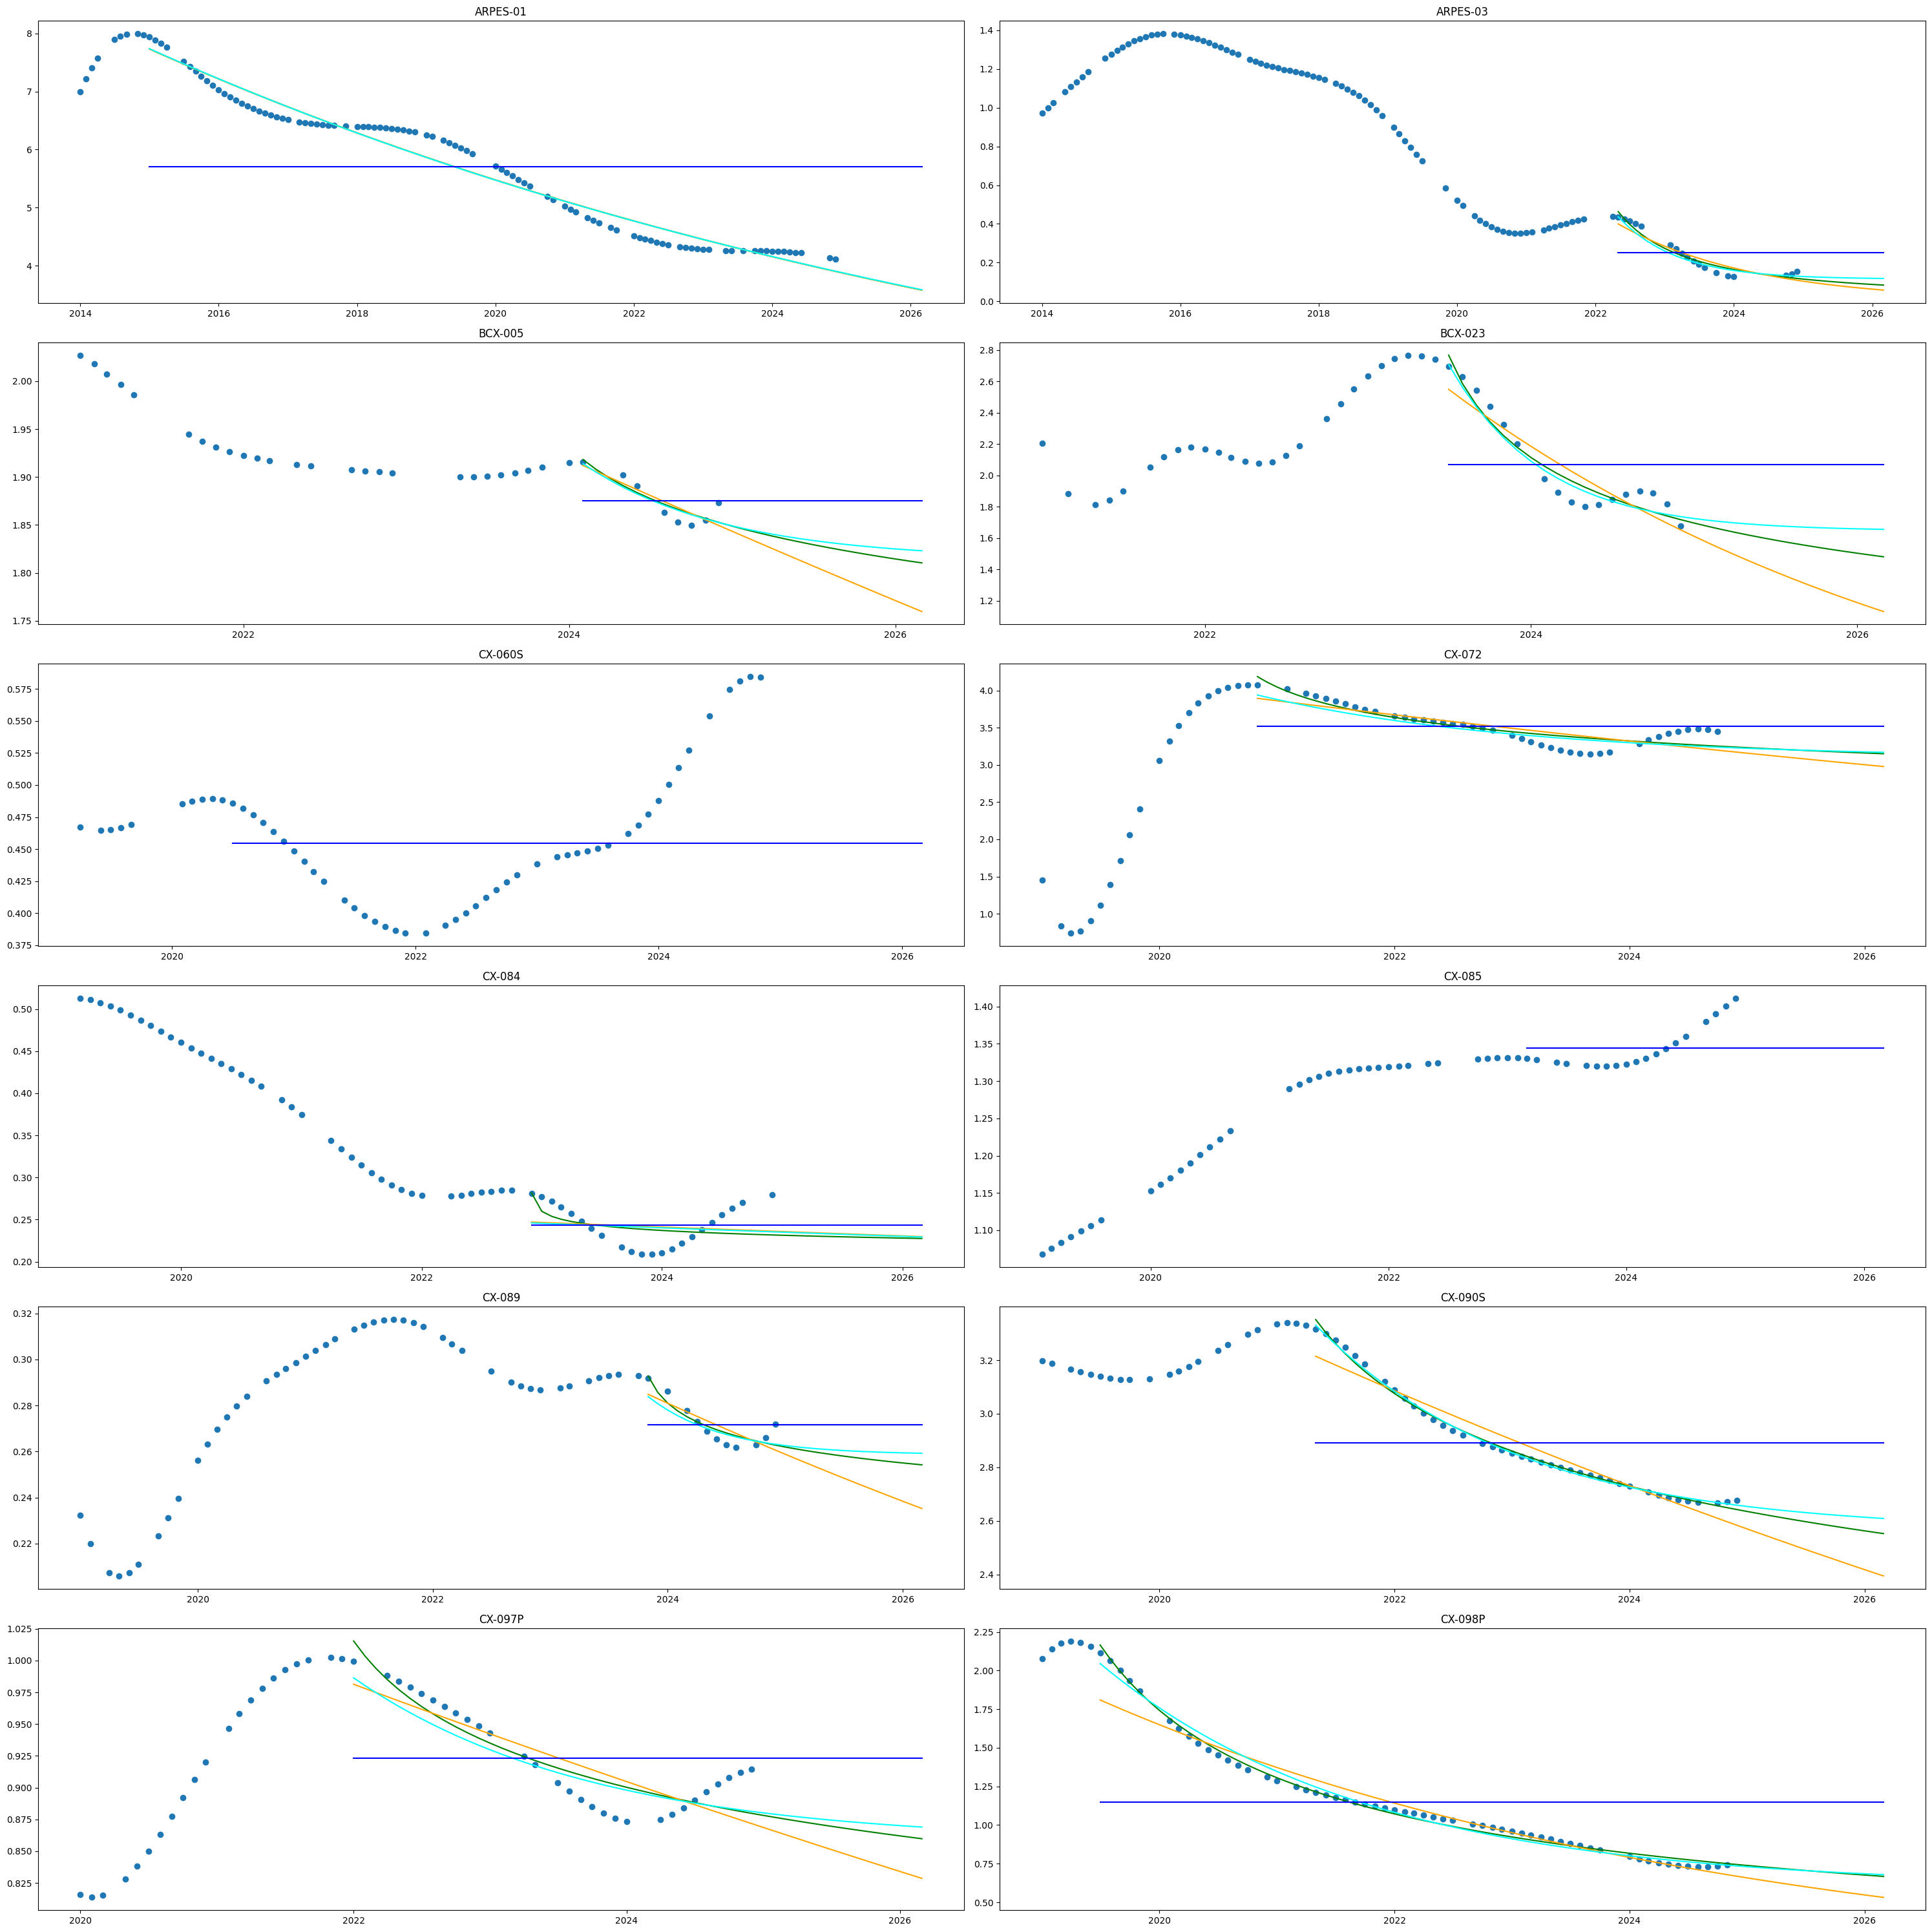

In [33]:
register_matplotlib_converters()

# Filter the dataframes
df_filtered = df[df['Pozo'].isin(pozosToPlot)].sort_values('Pozo')
resultsForecast_filtered = resultsForecast[resultsForecast['Pozo'].isin(pozosToPlot)]

# Get the unique Pozo values
pozos = df_filtered['Pozo'].unique()

# Create a figure and axes
fig, axs = plt.subplots(6, 2, figsize=(30, 30))  # Changed to 3 rows and 4 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over the Pozo values and create a subplot for each one
for i, pozo in enumerate(pozos):
    # Filter the dataframes for the current Pozo
    df_pozo = df_filtered[df_filtered['Pozo'] == pozo]
    resultsForecast_pozo = resultsForecast_filtered[resultsForecast_filtered['Pozo'] == pozo]

    # Plot the data
    axs[i].scatter(df_pozo['FechaMedicion'], df_pozo['Qs_l/s'])
    axs[i].plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Hyperbolic'], color='green')
    axs[i].plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Exponential'], color='orange')
    axs[i].plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Custodio'], color='cyan')
    axs[i].plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Constant'], color='blue')

    # Set the title
    axs[i].set_title(pozo)

    # Format the x-axis
    axs[i].xaxis.set_major_locator(mdates.YearLocator(2))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Automatically adjust subplot params so the subplot fits into the figure area
plt.tight_layout()

# Show the plot
plt.show()

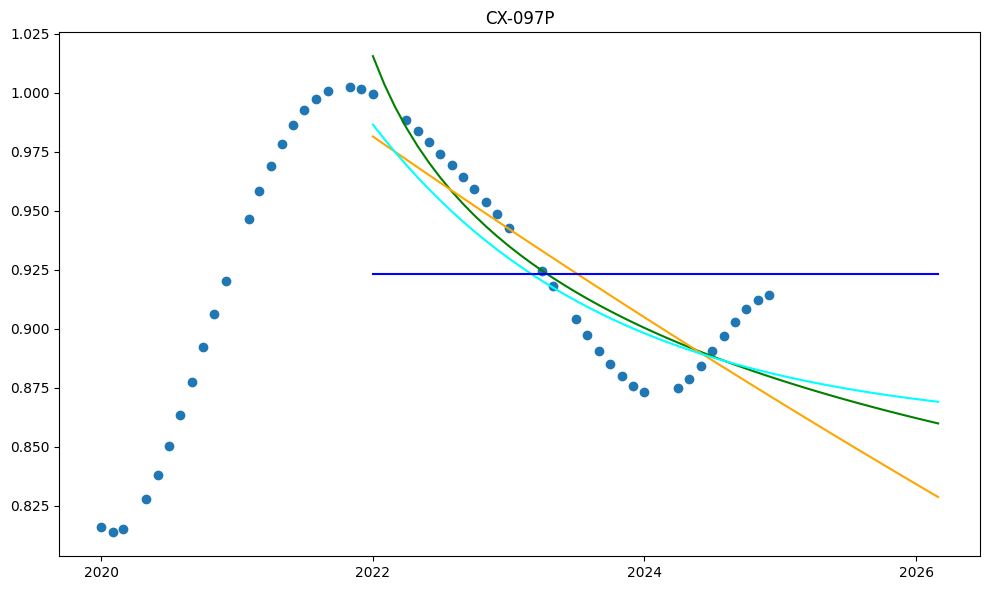

In [34]:
#Seleccionar un único pozo para graficar
pozo2 = 'CX-097P'
df_pozo = df[df['Pozo'] == pozo2]
resultsForecast_pozo = resultsForecast[resultsForecast['Pozo'] == pozo2]

# Create a figure and axes
fig, axs = plt.subplots(figsize=(10, 6))

# Plot the data
axs.scatter(df_pozo['FechaMedicion'], df_pozo['Qs_l/s'])
axs.plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Hyperbolic'], color='green')
axs.plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Exponential'], color='orange')
axs.plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Custodio'], color='cyan')
axs.plot(resultsForecast_pozo['Fecha'], resultsForecast_pozo['Forecast-Constant'], color='blue')

# Set the title
axs.set_title(pozo2)

# Format the x-axis
axs.xaxis.set_major_locator(mdates.YearLocator(2))
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Automatically adjust subplot params so the subplot fits into the figure area
plt.tight_layout()

# Show the plot
plt.show()

## 6-Exportar resultados de ajuste y proyección

In [39]:
# Exportar a Excel ajuste y proyección con los 4 métodos
with pd.ExcelWriter(ruta_out + "/" + 'Resultados Proyección_' + Filtrado + '_' + Suavizado + '_' + Selc_Tramo +'_.xlsx', engine='xlsxwriter') as writer:
    resultsForecast.to_excel(writer, sheet_name='Proyección por método')
    resultsDecline.reset_index().to_excel(writer, sheet_name='Parámetros de ajuste')

## 7-Selección de mejor ajuste

- En cada ejecución del script se importaran todas las proyecciones realizadas, tanto de las ejecuciones anteriores como de la actual, y se buscará cual de ellas es la mejor.
- Si se ha ejecutado el script con los datos de cada método de filtrado, de cada método de suavizado y usando cada método de selección de tramo, entonces se relizará la busqueda del mejor ajuste entre un total de 96 proyecciónes (caso extremo).

### 7.1-Cargar proyecciones realizadas

In [40]:
#Identificar resultados de las proyecciones

#Definir archivos de interés
Archivos_Interes1 = ['Resultados Proyección_DBSCAN_Spline_LastDecline_.xlsx',
                    'Resultados Proyección_DBSCAN_STL_LastDecline_.xlsx',
                    'Resultados Proyección_Hampel_Spline_LastDecline_.xlsx',
                    'Resultados Proyección_Hampel_STL_LastDecline_.xlsx',
                    'Resultados Proyección_IsolationForest_Spline_LastDecline_.xlsx',
                    'Resultados Proyección_IsolationForest_STL_LastDecline_.xlsx',
                    'Resultados Proyección_IQR_Spline_LastDecline_.xlsx',
                    'Resultados Proyección_IQR_STL_LastDecline_.xlsx']
Archivos_Interes2 = ['Resultados Proyección_DBSCAN_Spline_maxPendLast_.xlsx',
                    'Resultados Proyección_DBSCAN_STL_maxPendLast_.xlsx',
                    'Resultados Proyección_Hampel_Spline_maxPendLast_.xlsx',
                    'Resultados Proyección_Hampel_STL_maxPendLast_.xlsx',
                    'Resultados Proyección_IsolationForest_Spline_maxPendLast_.xlsx',
                    'Resultados Proyección_IsolationForest_STL_maxPendLast_.xlsx',
                    'Resultados Proyección_IQR_Spline_maxPendLast_.xlsx',
                    'Resultados Proyección_IQR_STL_maxPendLast_.xlsx']
Archivos_Interes3 = ['Resultados Proyección_DBSCAN_Spline_maxPendLast2_.xlsx',
                    'Resultados Proyección_DBSCAN_STL_maxPendLast2_.xlsx',
                    'Resultados Proyección_Hampel_Spline_maxPendLast2_.xlsx',
                    'Resultados Proyección_Hampel_STL_maxPendLast2_.xlsx',
                    'Resultados Proyección_IsolationForest_Spline_maxPendLast2_.xlsx',
                    'Resultados Proyección_IsolationForest_STL_maxPendLast2_.xlsx',
                    'Resultados Proyección_IQR_Spline_maxPendLast2_.xlsx',
                    'Resultados Proyección_IQR_STL_maxPendLast2_.xlsx']

Archivos_Interes = Archivos_Interes1 + Archivos_Interes2 + Archivos_Interes3

#Leer nombre de archivos xlsx disponibles en directorio
import os
ruta_in2 = ruta_out
contenido = os.listdir(ruta_in2)
Archivos_Disponibles = []
for fichero in contenido:
    if os.path.isfile(os.path.join(ruta_in2, fichero)) and fichero.endswith('.xlsx'):
        Archivos_Disponibles.append(fichero)
Archivos_Disponibles


['Resultados Proyección_Hampel_Spline_LastDecline_.xlsx']

In [41]:
#Buscar elementos comunes entre Archivos_Interes y Archivos_disponibles
Archivos = list(set(Archivos_Interes)&set(Archivos_Disponibles))
Archivos

['Resultados Proyección_Hampel_Spline_LastDecline_.xlsx']

In [42]:
#Cargar parámetros de los modelos de cada archivo y unir en un df
#Crear data frame para llenar
df_par = pd.DataFrame()

#Cargar cada archivo de interés disponible
for archivo in Archivos:
    df_par_in = pd.read_excel(ruta_in2 + "\\" + archivo, 'Parámetros de ajuste')

    #Eliminar columna "Unnamed: 0"
    df_par_in = df_par_in.drop('Unnamed: 0', axis=1)

    #Identificar Filtrado y Suavizado del archivo
    Filt = archivo.split(sep='_')[1]
    Suav = archivo.split(sep='_')[2]
    Dect_Tramo = archivo.split(sep='_')[3]


    #Crear columna que indique Filtrado, Suavizado y método detección de tramo
    df_par_in['Filtrado_Suavizado_DetTramo'] = Filt + '_' + Suav+'_'+ Dect_Tramo

    #Se unen los data frame con las columnas como eje de concatenación
    df_par = pd.concat([df_par,df_par_in],axis=0)

#df_par
df_par[df_par['Pozo']=='ARPES-01']

,Method,Pozo,gamma,b,d,q,delta,tau,R2real,R2internal,m,FechaDecline,Filtrado_Suavizado_DetTramo
0,Exponential,ARPES-01,NaN,0.000000e+00,0.000189,7.731308,NaN,NaN,0.963763,0.963776,-0.001042,2015-01-01,Hampel_Spline_LastDecline
368,Hyperbolic,ARPES-01,1.000000e-10,5.292393e-07,0.000189,7.731308,NaN,NaN,0.963763,0.963776,-0.001042,2015-01-01,Hampel_Spline_LastDecline
759,Custodio,ARPES-01,NaN,NaN,NaN,0.100000,76.362201,5195.290822,0.963646,0.963712,-0.001042,2015-01-01,Hampel_Spline_LastDecline
1139,Constant,ARPES-01,NaN,NaN,0.000000,5.709163,NaN,NaN,0.000000,0.000000,-0.001042,2015-01-01,Hampel_Spline_LastDecline


### 7.2-Selección del mejor ajuste-proyección

Para cada pozo se selecciona el mejor ajuste-proyección entre todas las opciones generadas. Recordar que, en cada ejecución del script, con una combinación distinta de entrada (filtrado, suavizado y método de detección de tramo), se generan 4 proyecciones por pozo (Hiperbólico, Exponencial, Constante y Custodio). Entre todas estas opciones se selecciona la mejor de ellas mediante 4 criterios:
- r2: primer criterio de selección. Se seleccionan aquellos ajustes que tengan el valor de r2 más alto. Para esto se evalúa el r2 hasta la décima.
- last_estim: segundo criterio de selección. Se seleccionan, entre los seleccionados por criterio anterior, los ajustes con proyecciones que generen un caudal final proyectado lo más alto posible. Se evalúa el caudal final proyectado hasta la décima.
- DTHG (diferencia con tendencia histórica global): tercer criterio de selección. Se selecciona, entre las proyecciones seleccionados previamente, aquella que presente una tendencia general lo más parecida a la tendencia global de toda la data histórica.
- Prioridad: en caso de que todos las métricas anteriores sean iguales para dos o más métodos, se cuenta con un orden de prioridad de los modelos. Esto está representado por valores de 0 a 3, siendo 0 la prioridad principal. Específicamente se asigna la prioridad de la siguiente manera: 0.Custodio, 1.Hiperbólico, 2.Exponencial y 3.Constante.

In [43]:
# Función para calcular last_estim y DTHG (r2 proviene de las funciones de ajuste de modelos)
def calcular_metricas_selección(Method, FechaDecline, r2, b, d, q, delta, tau, m_Q):
    time = pd.date_range(FechaDecline, end=pd.Timestamp(end_date), periods=5)
    days = (time - Last_Decline.loc[pozo,'DateDecline']).days
    last_day = days.max()   

    if Method == 'Hyperbolic':
        estim = q / ((1+d*b*days)**(1/b))
        last_estim = q / ((1+d*b*last_day)**(1/b))
    
    elif Method == 'Exponential':
        estim = q * np.exp(-d*days)
        last_estim = q * np.exp(-d*last_day)
    
    elif Method == 'Custodio':
        estim = q*(1+delta*np.exp(-days/tau))
        last_estim = q*(1+delta*np.exp(-last_day/tau))

    elif Method == 'Constant':
        estim = np.ones(len(days))*q
        last_estim = q
    
    m_proy = calcular_pendiente(days,estim)
    DTHG = np.log10(abs(m_Q-m_proy))
    return round(r2,1), round(last_estim,1), round(DTHG,5)

In [44]:
# Se aplica función para calcular parámetros de selección last_estim y DTHG y se almacenan en 'df_par'
df_par['tupla']=df_par.apply(lambda row: calcular_metricas_selección(row['Method'], row['FechaDecline'], row['R2real'], row['b'], row['d'], row['q'], row['delta'], row['tau'], row['m']), axis=1)   ###
df_par[['r2','last_estim','DTHG']] = pd.DataFrame(df_par['tupla'].tolist(), index=df_par.index)
df_par = df_par.drop(columns=['tupla'])
df_par=df_par.reset_index()

# En caso de que los parámetros sean iguales para todos los métods, sea crea un orden de prioridad
metodos_priorizados=['Custodio','Hyperbolic',  'Exponential','Constant']
df_par['Prioridad'] = df_par.reset_index()['Method'].apply(lambda x: metodos_priorizados.index(x) if x in metodos_priorizados else len(metodos_priorizados))

In [45]:
# Revisar los parámetros de selección en un pozo
df_par[df_par['Pozo']=='PC-D1-06'][['Method','Pozo','r2','last_estim','DTHG','Prioridad']]

,Method,Pozo,r2,last_estim,DTHG,Prioridad
34,Exponential,PC-D1-06,0.9,7.3,-3.43974,2
402,Hyperbolic,PC-D1-06,0.9,8.1,-3.99415,1
794,Custodio,PC-D1-06,0.9,8.6,-3.40754,0
1181,Constant,PC-D1-06,0.0,11.9,-2.63919,3


In [46]:
# Se obtiene el mejor ajuste-proyección mediante parámetros de selección
bestDecline=pd.DataFrame()

# Para cada pozo en 'df_par' se ordena r2 y 'last_estim' de forma descendente, y 'DTHG' y 'Prioridad' de forma ascendente.
sorted_results = df_par.sort_values(['Pozo','r2','last_estim','DTHG', 'Prioridad'], ascending=[True, False, False, True, True])

# Agrupa por 'Pozo' y toma la primera fila de cada grupo.
bestDecline = sorted_results.groupby('Pozo').head(1)

# Se establece 'Pozo' como el indice.
bestDecline = bestDecline.reset_index()
bestDecline = bestDecline.set_index('Pozo')
bestDecline

,level_0,index,Method,gamma,b,d,q,delta,tau,R2real,R2internal,m,FechaDecline,Filtrado_Suavizado_DetTramo,r2,last_estim,DTHG,Prioridad
Pozo,,,,,,,,,,,,,,,,,,
ARPES-01,368,368,Hyperbolic,1.000000e-10,5.292393e-07,0.000189,7.731308,NaN,NaN,0.963763,0.963776,-0.001042,2015-01-01,Hampel_Spline_LastDecline,1.0,4.9,-3.47094,1
ARPES-03,760,760,Custodio,NaN,NaN,NaN,0.114344,2.814400,309.105792,0.930134,0.779430,-0.000367,2022-05-01,Hampel_Spline_LastDecline,0.9,0.1,-3.44354,0
BCX-005,761,761,Custodio,NaN,NaN,NaN,1.813621,0.055210,320.864224,0.771111,0.649526,-0.000084,2024-02-01,Hampel_Spline_LastDecline,0.8,1.8,-4.08017,0
BCX-023,762,762,Custodio,NaN,NaN,NaN,1.645358,0.645150,212.462763,0.937528,0.769321,-0.000066,2023-07-01,Hampel_Spline_LastDecline,0.9,1.6,-4.18925,0
CX-060S,1143,1143,Constant,NaN,NaN,0.000000,0.454408,NaN,NaN,0.000000,0.000000,0.000029,2020-07-01,Hampel_Spline_LastDecline,0.0,0.5,-4.53677,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-408,754,754,Hyperbolic,2.329952e-02,4.849333e+00,0.004805,2.730691,NaN,NaN,0.832297,0.786713,-0.004553,2023-10-01,Hampel_Spline_LastDecline,0.8,1.2,-2.35386,1
XP-0268R,1135,1135,Custodio,NaN,NaN,NaN,0.100000,33.336335,268.166013,0.797704,0.874212,-0.000736,2023-07-01,Hampel_Spline_LastDecline,0.8,0.1,-3.14086,0
XP-0284,756,756,Hyperbolic,5.963623e-02,8.020568e+00,0.007435,1.738465,NaN,NaN,0.324690,0.227426,0.000042,2020-05-01,Hampel_Spline_LastDecline,0.3,0.9,-3.79403,1


### 7.3-Intervalo de confianza para mejor ajuste-proyección y correción a último dato

Se definen las funciones para obtener los invervalos de confianza y la correción al último dato real

In [47]:
# Funciones para generar intervalo de confianza para ajuste-proyección Hiperbólica
def calcular_limites_confianza_hiperb(q0, d0, b, t_futuro, logQ, t_pasado):
    """
    Calcula los límites de confianza para las proyecciones hiperbólicas futuras.

    :param q0: Parámetro q0 de la función hiperbólica.
    :param d0: Parámetro d0 de la función hiperbólica.
    :param b: Parámetro b de la función hiperbólica.
    :param t_futuro: Serie de tiempo para las proyecciones futuras.
    :param logQ: Logaritmo natural de los caudales históricos.
    :param t_pasado: Tiempo histórico correspondiente a los caudales.
    :return: Límites de confianza inferiores y superiores.
    """

    alpha = 0.3  # Nivel de confianza (70%)

    ultimo_indice_cero = t_pasado[t_pasado == 0].last_valid_index()
    t_pasado=t_pasado.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    logQ=logQ.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    n = len(logQ) # Número de observaciones históricas

    # Predicciones futuras en la escala original (no logarítmica)
    Q_pred_futuro = q0 / ((1 + d0 * b * t_futuro) ** (1/b))

    # Residuos de los datos históricos en la escala original (no logarítmica)
    Q_pred_pasado = q0 / ((1 + d0 * b * t_pasado) ** (1/b))
    residuos = Q_pred_pasado - np.exp(logQ)
    mse = np.sum(residuos**2) / (n - 2)  # -2 porque tenemos 2 parámetros
    s_error = np.sqrt(mse)
   
    # Calcula el error estándar de la predicción para el futuro
    se_pred = s_error * np.sqrt(1/n + abs(t_futuro - np.mean(t_pasado))**2 / np.sum((t_pasado - np.mean(t_pasado))**2))
    t_value = t.ppf(1 - alpha/2, df=n - 2)

    # Límites de confianza en la escala original (no logarítmica)
    conf_interval = t_value * se_pred
    lower_bound = Q_pred_futuro - conf_interval
    upper_bound = Q_pred_futuro + conf_interval

    return lower_bound, upper_bound

def proyecciones_con_limites(pozo, df, bestDecline):
    """
    Calcula las proyecciones y sus límites de confianza para un pozo dado.

    :param pozo: Nombre del pozo.
    :param df: DataFrame con los datos históricos.
    :param bestDecline: DataFrame con los mejores parámetros de declive.
    :return: DataFrame con las proyecciones y límites de confianza.
    """
    # Obtener los parámetros para el pozo específico
    parametros = bestDecline.loc[pozo]
    q0 = parametros['q']
    d0 = parametros['d']
    b = parametros['b']

    # Datos históricos para el pozo
    datos_pozo = df[df['Pozo'] == pozo]
    t_pasado = datos_pozo['FechaMedicion'].apply(lambda x: (x - bestDecline.loc[pozo,'FechaDecline']).days)
    logQ = np.log(datos_pozo['Qf_l/s'])

    # Rango de tiempo futuro
    time = pd.date_range(bestDecline.loc[pozo,'FechaDecline'], end=pd.Timestamp(end_date), freq='MS')
    dias_futuros = (time - bestDecline.loc[pozo,'FechaDecline']).days
    
    # Calcular las proyecciones futuras
    proyecciones = q0 / ((1 + d0 * b * dias_futuros) ** (1/b))
    
    # Calcular las proyecciones y los límites de confianza
    lower_bound, upper_bound = calcular_limites_confianza_hiperb(q0, d0, b, dias_futuros, logQ, t_pasado)

    # Agregar caudal real filtrado
    fecha_decline = bestDecline.loc[pozo,'FechaDecline']
    fecha_finalQf = datos_pozo.dropna(subset=['Qf_l/s'])['FechaMedicion'].max()
    all_dates = pd.date_range(start=fecha_decline, end=fecha_finalQf, freq='MS')
    pozo_fecha = pd.MultiIndex.from_product([datos_pozo['Pozo'].unique(), all_dates], names=['Pozo', 'FechaMedicion']).to_frame(index=False)
    Qf = pd.merge(datos_pozo, pozo_fecha, on=['Pozo', 'FechaMedicion'], how='right')['Qf_l/s'].to_numpy().tolist()
    Qf.extend([np.nan]*(len(time)-len(Qf)))

    # Preparar el DataFrame con los resultados
    forecastDf = pd.DataFrame({
        'Pozo': pozo,
        'Fecha': time,
        'Q_real_filtrado (L/s)': Qf,
        'Forecast (L/s)': proyecciones,
        'LowerBound': lower_bound,
        'UpperBound': upper_bound
    })

    # Corrección a último dato
    fechaMedicion_final = datos_pozo.dropna()['FechaMedicion'].max()

    indice_Qf_final = datos_pozo.dropna().last_valid_index()
    Qf_final = datos_pozo['Qf_l/s'][indice_Qf_final]

    indice_Qmodelo_Qf_final = forecastDf[forecastDf['Fecha'] == fechaMedicion_final].last_valid_index()
    Qmodelo_Qf_final = forecastDf['Forecast (L/s)'][indice_Qmodelo_Qf_final]

    correccion_datofinal = Qf_final - Qmodelo_Qf_final

    # Aplicar correción
    forecastDf['Forecast (L/s)'] = np.where(time >= fechaMedicion_final, proyecciones + correccion_datofinal, proyecciones)
    forecastDf['LowerBound'] = np.where(time >= fechaMedicion_final, lower_bound + correccion_datofinal, lower_bound)
    forecastDf['UpperBound'] = np.where(time >= fechaMedicion_final, upper_bound + correccion_datofinal, upper_bound)

    return forecastDf

In [48]:
# Funciones para generar intervalo de confianza para ajuste-proyección Exponencial
def calcular_limites_confianza_exp(q, d, t_futuro, logQ, t_pasado):

    alpha = 0.05

    # Predicciones futuras en la escala logarítmica
    log_Q_pred_futuro = np.log(q) - d * t_futuro


    ultimo_indice_cero = t_pasado[t_pasado == 0].last_valid_index()
    t_pasado=t_pasado.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    logQ=logQ.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    n = len(logQ)


    # Residuos de los datos históricos en la escala logarítmica
    log_Q_pred_pasado = np.log(q) - d * t_pasado
    residuos_log = log_Q_pred_pasado - logQ
    mse_log = np.sum(residuos_log**2) / (n - 2)  # -2 porque tenemos 2 parámetros
    s_error_log = np.sqrt(mse_log)

    # Calcula el error estándar de la predicción para el futuro en la escala logarítmica
    se_pred_log = s_error_log * np.sqrt(1/n + (t_futuro - np.mean(t_pasado))**2 / np.sum((t_pasado - np.mean(t_pasado))**2))
    t_value = t.ppf(1 - alpha/2, df=n - 2)

    # Límites de confianza en la escala logarítmica y luego transformados de vuelta a la escala original
    conf_interval_log = t_value * se_pred_log
    lower_bound_log = log_Q_pred_futuro - conf_interval_log
    upper_bound_log = log_Q_pred_futuro + conf_interval_log

    lower_bound = np.exp(lower_bound_log)
    upper_bound = np.exp(upper_bound_log)

    return lower_bound, upper_bound


def proyecciones_con_limites_exp(pozo, df, bestDecline):
    
    # Obtener los parámetros para el pozo específico
    parametros = bestDecline.loc[pozo]
    q = parametros['q']
    d = parametros['d']

    # Datos históricos para el pozo
    datos_pozo = df[df['Pozo'] == pozo]
    t_pasado = datos_pozo['FechaMedicion'].apply(lambda x: (x - bestDecline.loc[pozo,'FechaDecline']).days)
    logQ = np.log(datos_pozo['Qf_l/s'])

    # Rango de tiempo futuro
    time = pd.date_range(bestDecline.loc[pozo,'FechaDecline'], end=pd.Timestamp(end_date), freq='MS')
    dias_futuros = (time - bestDecline.loc[pozo,'FechaDecline']).days

    # Calcular las proyecciones futuras
    proyecciones = q * np.exp(-d * dias_futuros)

    # Calcular las proyecciones y los límites de confianza
    lower_bound, upper_bound = calcular_limites_confianza_exp(q, d, dias_futuros, logQ, t_pasado)

    # Agregar caudal filtrado real
    fecha_decline = bestDecline.loc[pozo,'FechaDecline']
    fecha_finalQf = datos_pozo.dropna(subset=['Qf_l/s'])['FechaMedicion'].max()
    all_dates = pd.date_range(start=fecha_decline, end=fecha_finalQf, freq='MS')
    pozo_fecha = pd.MultiIndex.from_product([datos_pozo['Pozo'].unique(), all_dates], names=['Pozo', 'FechaMedicion']).to_frame(index=False)
    Qf = pd.merge(datos_pozo, pozo_fecha, on=['Pozo', 'FechaMedicion'], how='right')['Qf_l/s'].to_numpy().tolist()
    Qf.extend([np.nan]*(len(time)-len(Qf)))

    forecastDf = pd.DataFrame({
        'Pozo': pozo,
        'Fecha': time,
        'Q_real_filtrado (L/s)': Qf,
        'Forecast (L/s)': proyecciones,
        'LowerBound': lower_bound,
        'UpperBound': upper_bound
    })
    
    # Corrección a último dato
    fechaMedicion_final = datos_pozo.dropna()['FechaMedicion'].max()

    indice_Qf_final = datos_pozo.dropna().last_valid_index()
    Qf_final = datos_pozo['Qf_l/s'][indice_Qf_final]

    indice_Qmodelo_Qf_final = forecastDf[forecastDf['Fecha'] == fechaMedicion_final].last_valid_index()
    Qmodelo_Qf_final = forecastDf['Forecast (L/s)'][indice_Qmodelo_Qf_final]

    correccion_datofinal = Qf_final - Qmodelo_Qf_final

    # Aplicar correción
    forecastDf['Forecast (L/s)'] = np.where(time >= fechaMedicion_final, proyecciones + correccion_datofinal, proyecciones)
    forecastDf['LowerBound'] = np.where(time >= fechaMedicion_final, lower_bound + correccion_datofinal, lower_bound)
    forecastDf['UpperBound'] = np.where(time >= fechaMedicion_final, upper_bound + correccion_datofinal, upper_bound)

    return forecastDf

In [49]:
# Funciones para generar intervalo de confianza para ajuste-proyección Constante
def calcular_limites_confianza_constante(q, t_futuro, logQ, t_pasado):
    
    n = len(logQ)
    alpha = 0.05  # Nivel de confianza (95%)

    ultimo_indice_cero = t_pasado[t_pasado == 0].last_valid_index()
    t_pasado=t_pasado.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    logQ=logQ.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    n = len(logQ) # Número de observaciones históricas

    # La predicción futura es simplemente la media (q)
    Q_pred_futuro = q

    # Residuos de los datos históricos en la escala original (no logarítmica)
    Q_pred_pasado = q
    residuos = Q_pred_pasado - np.exp(logQ)
    mse = np.sum(residuos**2) / (n - 2)  # -2 porque tenemos 2 parámetros
    s_error = np.sqrt(mse)

    # Calcula el error estándar de la predicción para el futuro
    se_pred = s_error * np.sqrt(1/n + abs(t_futuro - np.mean(t_pasado))**2 / np.sum((t_pasado - np.mean(t_pasado))**2))
    t_value = t.ppf(1 - alpha/2, df=n - 2)

    # Límites de confianza
    conf_interval = t_value * se_pred
    lower_bound = Q_pred_futuro - conf_interval
    upper_bound = Q_pred_futuro + conf_interval

    return lower_bound, upper_bound
def proyecciones_con_limites_constante(pozo, df, bestDecline):
    
    # Obtener los parámetros para el pozo específico
    parametros = bestDecline.loc[pozo]
    q = parametros['q']

    # Datos históricos para el pozo
    datos_pozo = df[df['Pozo'] == pozo]
    t_pasado = datos_pozo['FechaMedicion'].apply(lambda x: (x - bestDecline.loc[pozo,'FechaDecline']).days)
    logQ = np.log(datos_pozo['Qf_l/s'])

    # Rango de tiempo futuro
    time = pd.date_range(bestDecline.loc[pozo,'FechaDecline'], end=pd.Timestamp(end_date), freq='MS')
    dias_futuros = (time - bestDecline.loc[pozo,'FechaDecline']).days

    # Calcular las proyecciones futuras, la proyección es constante
    proyecciones = np.full(len(time), q)

    # Calcular las proyecciones y los límites de confianza
    lower_bound, upper_bound = calcular_limites_confianza_constante(q, dias_futuros, logQ, t_pasado)

    # Agregar caudal filtrado real
    fecha_decline = bestDecline.loc[pozo,'FechaDecline']
    fecha_finalQf = datos_pozo.dropna(subset=['Qf_l/s'])['FechaMedicion'].max()
    all_dates = pd.date_range(start=fecha_decline, end=fecha_finalQf, freq='MS')
    pozo_fecha = pd.MultiIndex.from_product([datos_pozo['Pozo'].unique(), all_dates], names=['Pozo', 'FechaMedicion']).to_frame(index=False)
    Qf = pd.merge(datos_pozo, pozo_fecha, on=['Pozo', 'FechaMedicion'], how='right')['Qf_l/s'].to_numpy().tolist()
    Qf.extend([np.nan]*(len(time)-len(Qf)))

    forecastDf = pd.DataFrame({
        'Pozo': pozo,
        'Fecha': time,
        'Q_real_filtrado (L/s)': Qf,
        'Forecast (L/s)': proyecciones,
        'LowerBound': lower_bound,
        'UpperBound': upper_bound
    })

    # Corrección a último dato
    fechaMedicion_final = datos_pozo.dropna()['FechaMedicion'].max()

    indice_Qf_final = datos_pozo.dropna().last_valid_index()
    Qf_final = datos_pozo['Qf_l/s'][indice_Qf_final]

    indice_Qmodelo_Qf_final = forecastDf[forecastDf['Fecha'] == fechaMedicion_final].last_valid_index()
    Qmodelo_Qf_final = forecastDf['Forecast (L/s)'][indice_Qmodelo_Qf_final]

    correccion_datofinal = Qf_final - Qmodelo_Qf_final

    # Aplicar correción
    forecastDf['Forecast (L/s)'] = np.where(time >= fechaMedicion_final, proyecciones + correccion_datofinal, proyecciones)
    forecastDf['LowerBound'] = np.where(time >= fechaMedicion_final, lower_bound + correccion_datofinal, lower_bound)
    forecastDf['UpperBound'] = np.where(time >= fechaMedicion_final, upper_bound + correccion_datofinal, upper_bound)


    return forecastDf

In [50]:
# Funciones para generar intervalo de confianza para ajuste-proyección Custodio
def calcular_limites_confianza_custodio(q, delta, tau, t_futuro, caudal, t_pasado):
    """
    Calcula los límites de confianza para las proyecciones de Custodio.

    :param q: Parámetro q del modelo de Custodio.
    :param delta: Parámetro delta del modelo de Custodio.
    :param tau: Parámetro tau del modelo de Custodio.
    :param t_futuro: Serie de tiempo para las proyecciones futuras.
    :param caudal: Caudales históricos.
    :param t_pasado: Tiempo histórico correspondiente a los caudales.
    :return: Límites de confianza inferiores y superiores.
    """
    alpha = 0.3  # Nivel de confianza (70%)

    # Predicciones futuras
    Q_pred_futuro = q * (1 + delta * np.exp(-t_futuro / tau))

    # Residuos de los datos históricos
    ultimo_indice_cero = t_pasado[t_pasado == 0].last_valid_index()
    t_pasado=t_pasado.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    caudal=caudal.loc[ultimo_indice_cero:ultimo_indice_cero+len(t_pasado)]
    n = len(caudal) # Número de observaciones históricas
    
    Q_pred_pasado = q * (1 + delta * np.exp(-t_pasado / tau))
    residuos = Q_pred_pasado - caudal
    mse = np.sum(residuos**2) / (n - 2)  # -2 porque tenemos 2 parámetros (delta y tau)
    s_error = np.sqrt(mse)
    
    # Calcula el error estándar de la predicción para el futuro
    se_pred = s_error * np.sqrt(1/n + (t_futuro - np.mean(t_pasado))**2 / np.sum((t_pasado - np.mean(t_pasado))**2))
    t_value = t.ppf(1 - alpha/2, df=n - 2)

    # Límites de confianza
    conf_interval = t_value * se_pred
    lower_bound = Q_pred_futuro - conf_interval
    upper_bound = Q_pred_futuro + conf_interval

    return lower_bound, upper_bound


def proyecciones_con_limites_custodio(pozo, df, bestDecline):
    """
    Calcula las proyecciones y sus límites de confianza para un pozo dado utilizando el modelo de Custodio.

    :param pozo: Nombre del pozo.
    :param df: DataFrame con los datos históricos.
    :param bestDecline: DataFrame con los mejores parámetros de declive según el método de Custodio.
    :return: DataFrame con las proyecciones y límites de confianza.
    """
    # Obtener los parámetros para el pozo específico
    parametros = bestDecline.loc[pozo]
    q = parametros['q']
    delta = parametros['delta']
    tau = parametros['tau']

    # Datos históricos para el pozo
    datos_pozo = df[df['Pozo'] == pozo]
    t_pasado = (datos_pozo['FechaMedicion'] - bestDecline.loc[pozo, 'FechaDecline']).dt.days.clip(lower=0)
    caudal = datos_pozo['Qf_l/s']

    # Rango de tiempo futuro
    time = pd.date_range(bestDecline.loc[pozo,'FechaDecline'], end=pd.Timestamp(end_date), freq='MS')
    dias_futuros = (time - bestDecline.loc[pozo,'FechaDecline']).days
    
   # Calcular las proyecciones futuras
    proyecciones = q * (1 + delta * np.exp(-dias_futuros / tau))

    # Calcular las proyecciones y los límites de confianza
    lower_bound, upper_bound = calcular_limites_confianza_custodio(q, delta, tau, dias_futuros, caudal, t_pasado)

    # Agregar caudal filtrado real
    fecha_decline = bestDecline.loc[pozo,'FechaDecline']
    fecha_finalQf = datos_pozo.dropna(subset=['Qf_l/s'])['FechaMedicion'].max()
    all_dates = pd.date_range(start=fecha_decline, end=fecha_finalQf, freq='MS')
    pozo_fecha = pd.MultiIndex.from_product([datos_pozo['Pozo'].unique(), all_dates], names=['Pozo', 'FechaMedicion']).to_frame(index=False)
    Qf = pd.merge(datos_pozo, pozo_fecha, on=['Pozo', 'FechaMedicion'], how='right')['Qf_l/s'].to_numpy().tolist()
    Qf.extend([np.nan]*(len(time)-len(Qf)))

    # Preparar el DataFrame con los resultados
    forecastDf = pd.DataFrame({
        'Pozo': pozo,
        'Fecha': time,
        'Q_real_filtrado (L/s)': Qf,
        'Forecast (L/s)': proyecciones,
        'LowerBound': lower_bound,
        'UpperBound': upper_bound
    })

    # Corrección a último dato
    fechaMedicion_final = datos_pozo.dropna()['FechaMedicion'].max()

    indice_Qf_final = datos_pozo.dropna().last_valid_index()
    Qf_final = datos_pozo['Qf_l/s'][indice_Qf_final]

    indice_Qmodelo_Qf_final = forecastDf[forecastDf['Fecha'] == fechaMedicion_final].last_valid_index()
    Qmodelo_Qf_final = forecastDf['Forecast (L/s)'][indice_Qmodelo_Qf_final]

    correccion_datofinal = Qf_final - Qmodelo_Qf_final

    # Aplicar correción
    forecastDf['Forecast (L/s)'] = np.where(time >= fechaMedicion_final, proyecciones + correccion_datofinal, proyecciones)
    forecastDf['LowerBound'] = np.where(time >= fechaMedicion_final, lower_bound + correccion_datofinal, lower_bound)
    forecastDf['UpperBound'] = np.where(time >= fechaMedicion_final, upper_bound + correccion_datofinal, upper_bound)

    return forecastDf

In [51]:
#Identificar filtrados y suavizados de los mejores ajustes-proyección
FiltradoSuavizado_bestDecline = bestDecline['Filtrado_Suavizado_DetTramo'].str.split('_', expand=True)
filtrados_suavizado_List = list((FiltradoSuavizado_bestDecline[0] + '_' + FiltradoSuavizado_bestDecline[1]).unique())
filtrados_suavizado_List

['Hampel_Spline']

In [55]:
#Importar datos filtrados de los mejores ajustes-proyección
List_df_QfQs = []
for i in range(len(filtrados_suavizado_List)):
    filt = filtrados_suavizado_List[i].split(sep='_')[0]
    suav = filtrados_suavizado_List[i].split(sep='_')[1]

    #Importar datos
    df_QfQs_i = pd.read_excel(r'E:\9_Desarrollo\UDD\Analisis_de_Datos\Data\Inputs_Ajuste\Q_Suavizado_Spline (Filtrado STL).xlsx')

    #Tomar solo columnas de interes
    df_QfQs_interes = df_QfQs_i[['Fecha', 'Pozo', 'Caudal_Filtrado', 'Caudal_Filtrado_Suavizado']].copy()

    #Renombrar columnas
    df_QfQs_interes = df_QfQs_interes.rename(columns={'Caudal_Filtrado': 'Qf_l/s', 'Fecha': 'FechaMedicion', 'Caudal_Filtrado_Suavizado': 'Qs_l/s'})

    #Adjuntar a la lista de data frames el data frame cargado
    List_df_QfQs.append(df_QfQs_interes)
    #List_df_QfQs

In [56]:
# Calcular las proyecciones y límites para cada pozo con su mejor ajuste-proyección
resultsForecast_bestDecline = pd.DataFrame()

for pozo in pozosList:
    method = bestDecline.loc[pozo, 'Method']  # Método seleccionado para cada pozo
    filtro = bestDecline.loc[pozo,'Filtrado_Suavizado_DetTramo'].split(sep='_')[0]   # Filtrado seleccionado para cada pozo
    suavi = bestDecline.loc[pozo,'Filtrado_Suavizado_DetTramo'].split(sep='_')[1]   # Suavizado seleccionado para cada pozo

    df_Qf = List_df_QfQs[filtrados_suavizado_List.index(filtro+ '_' +suavi)]    # Data frame con los caudales filtrados y suavizados
    
    if method == 'Hyperbolic':
        forecastDf = proyecciones_con_limites(pozo, df_Qf, bestDecline)
    elif method == 'Exponential':
        forecastDf = proyecciones_con_limites_exp(pozo, df_Qf, bestDecline)
    elif method == 'Constant':
        forecastDf = proyecciones_con_limites_constante(pozo, df_Qf, bestDecline)
    elif method == 'Custodio':
        forecastDf = proyecciones_con_limites_custodio(pozo, df_Qf, bestDecline)
    else:
        print("Warning: No method for pozo " + str(pozo))
        continue

    resultsForecast_bestDecline = pd.concat([resultsForecast_bestDecline, forecastDf], axis=0)

resultsForecast_bestDecline

,Pozo,Fecha,Q_real_filtrado (L/s),Forecast (L/s),LowerBound,UpperBound
0,ARPES-01,2015-01-01,7.953326,7.731308,7.677582,7.785034
1,ARPES-01,2015-02-01,7.938677,7.686155,7.633114,7.739195
2,ARPES-01,2015-03-01,7.942446,7.645598,7.593174,7.698022
3,ARPES-01,2015-04-01,7.880897,7.600945,7.549200,7.652690
4,ARPES-01,2015-05-01,NaN,7.557981,7.506890,7.609071
...,...,...,...,...,...,...
50,W-UC-14,2025-11-01,NaN,2.635182,2.422100,2.848264
51,W-UC-14,2025-12-01,NaN,2.635182,2.416068,2.854295
52,W-UC-14,2026-01-01,NaN,2.635182,2.409812,2.860551
53,W-UC-14,2026-02-01,NaN,2.635182,2.403534,2.866829


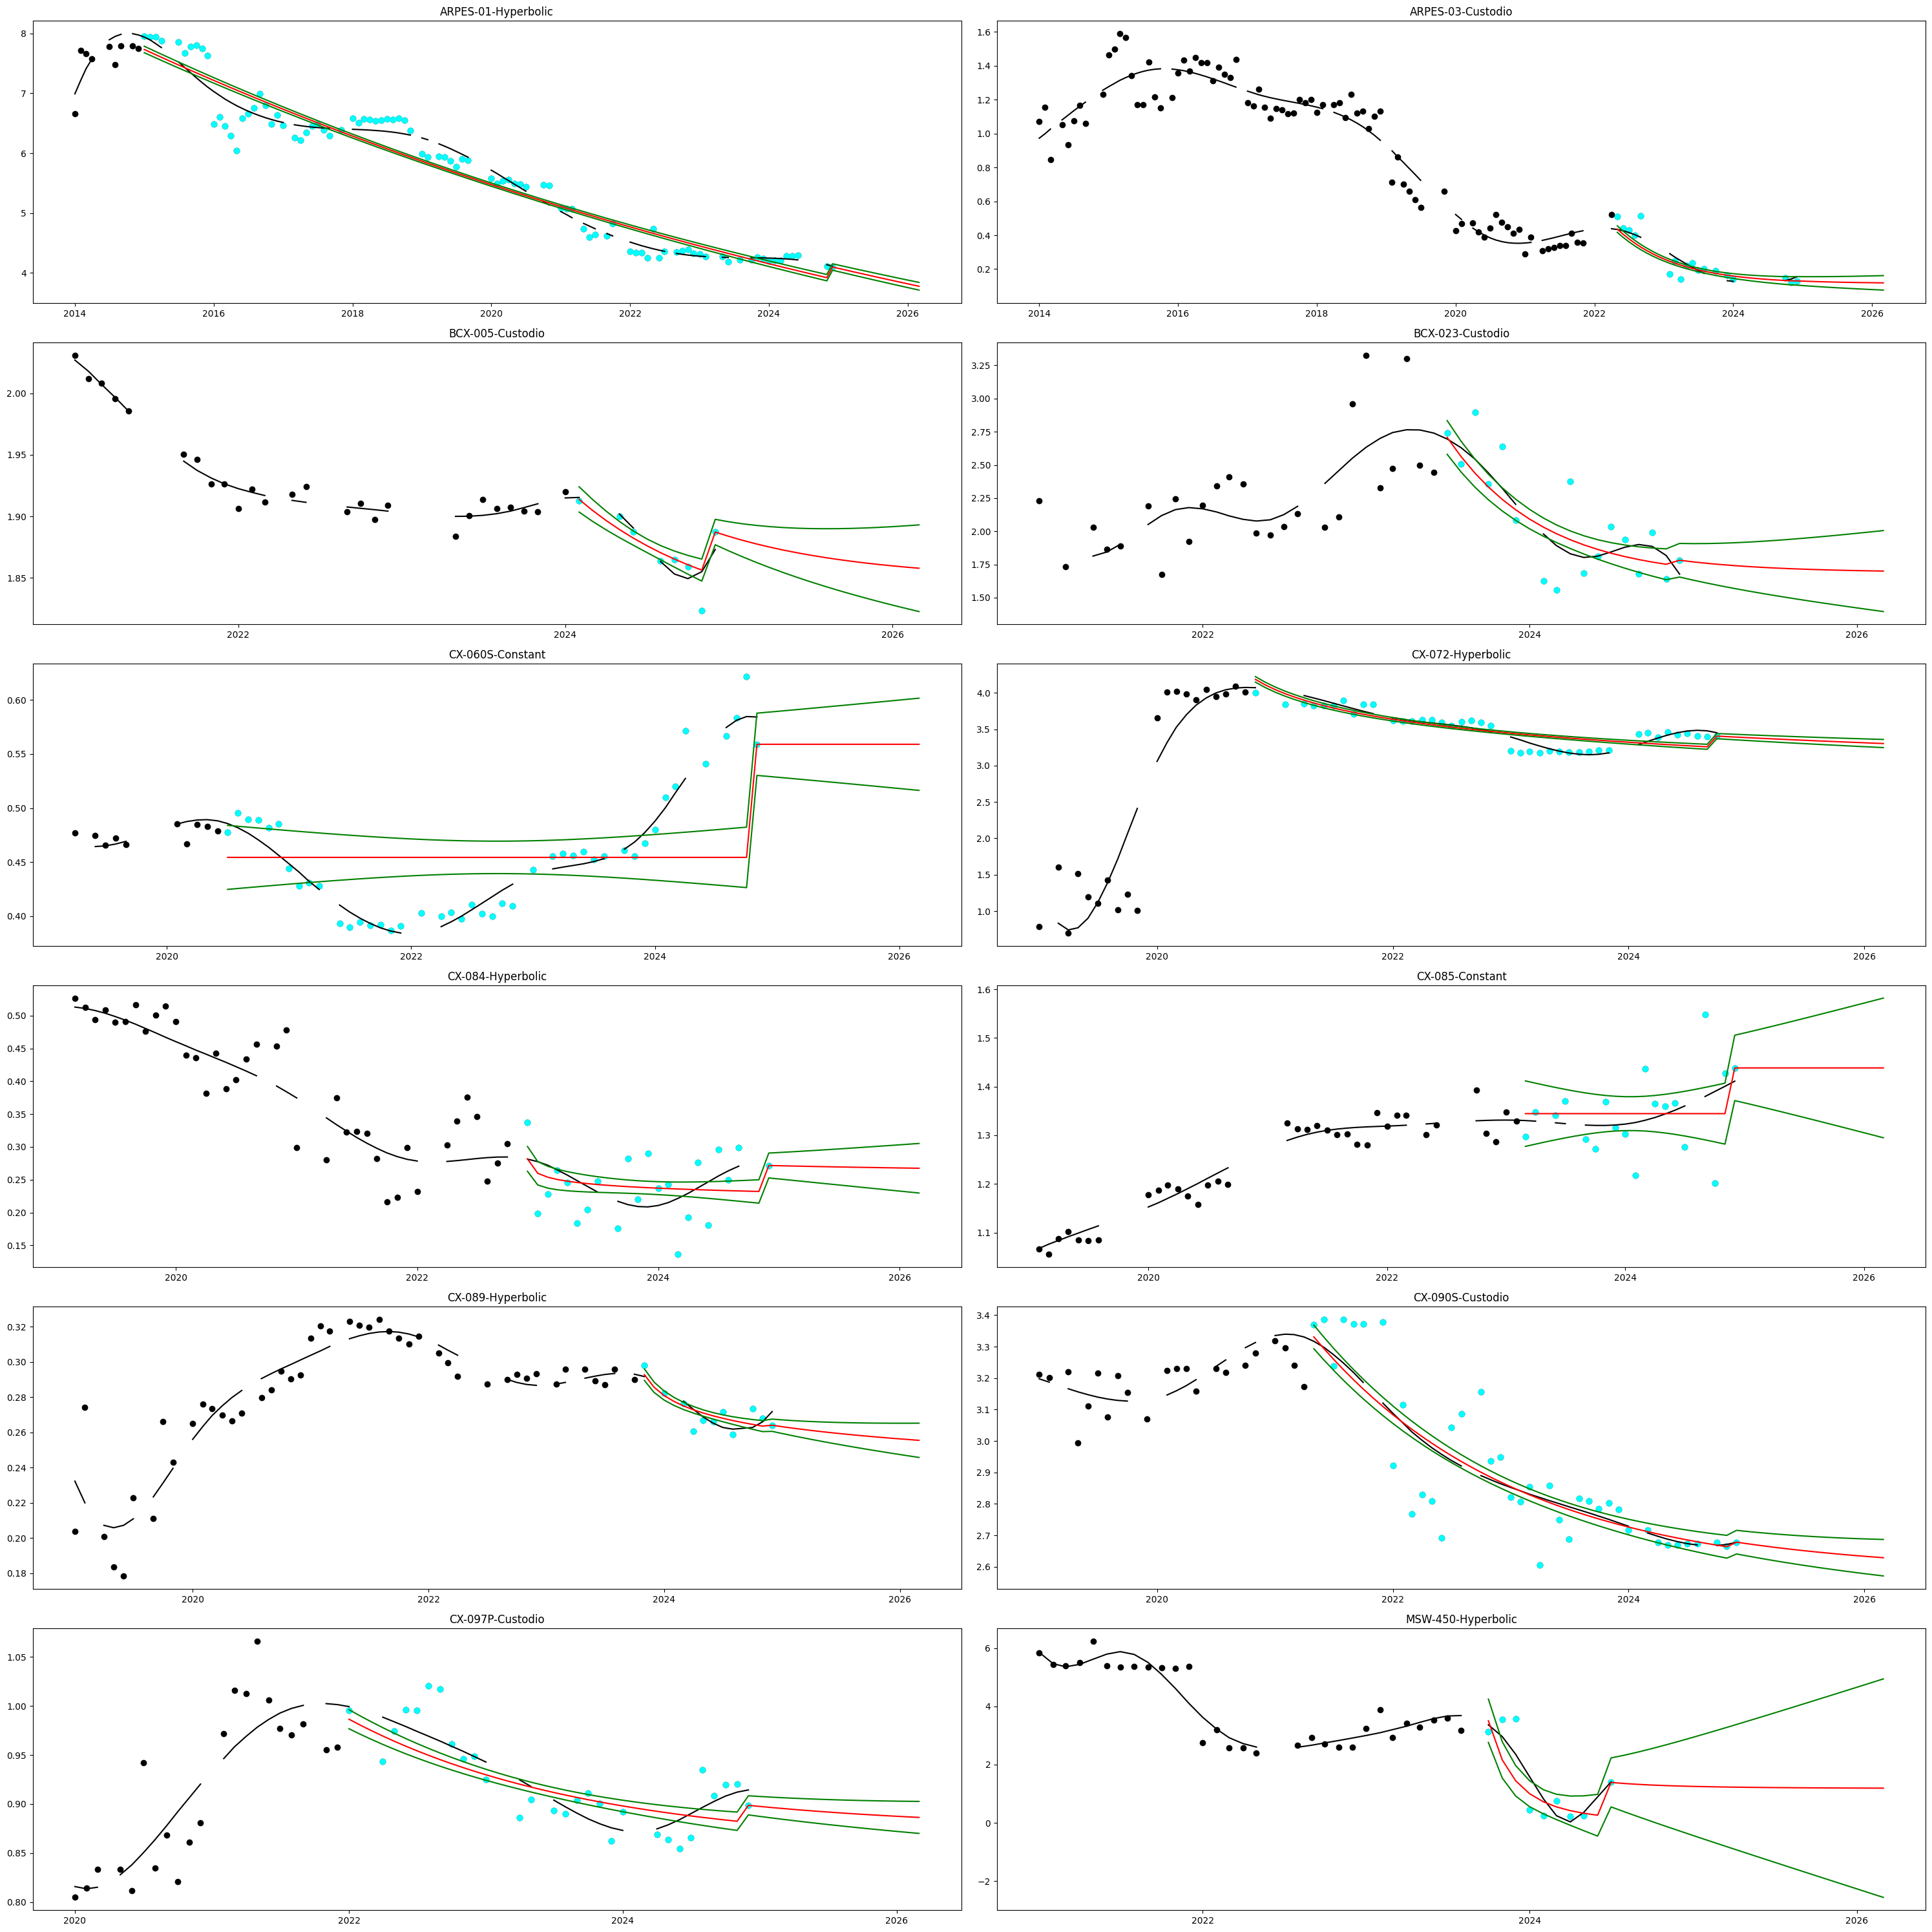

In [57]:
# Graficar algunos ejemplos
pozosToPlot = ['ARPES-01', 'ARPES-03', 'BCX-005', 'BCX-023', 'CX-060S', 'CX-072', 'CX-084', 'CX-085', 'CX-089', 'CX-090S', 'CX-097P', 'MSW-450']

#pozosToPlot = pozosList[:12] 
#pozosToPlot = pozosList[12:24]
#pozosToPlot = pozosList[24:36]
#pozosToPlot = pozosList[36:48]
#pozosToPlot = pozosList[48:60]
#pozosToPlot = pozosList[60:72]
#pozosToPlot = pozosList[70:82]
#pozosToPlot = pozosList[80:92]
#pozosToPlot = pozosList[92:104]

register_matplotlib_converters()

# Filter the dataframes
df_filtered = df[df['Pozo'].isin(pozosToPlot)].sort_values('Pozo')
resultsForecast_bestDecline_filtered = resultsForecast_bestDecline[resultsForecast_bestDecline['Pozo'].isin(pozosToPlot)]

# Get the unique Pozo values
pozos = df_filtered['Pozo'].unique()

# Create a figure and axes
fig, axs = plt.subplots(6, 2, figsize=(30, 30))  # Changed to 3 rows and 4 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over the Pozo values and create a subplot for each one
for i, pozo in enumerate(pozos):

    method = bestDecline.loc[pozo, 'Method']  # Método seleccionado para cada pozo
    filtro = bestDecline.loc[pozo,'Filtrado_Suavizado_DetTramo'].split(sep='_')[0]   # Filtrado seleccionado para cada pozo
    suavi = bestDecline.loc[pozo,'Filtrado_Suavizado_DetTramo'].split(sep='_')[1]   # Suavizado seleccionado para cada pozo

    df_Qf = List_df_QfQs[filtrados_suavizado_List.index(filtro+ '_' +suavi)]    # Data frame con los caudales filtrados y suavizados
    df_Qf = df_Qf[df_Qf['Pozo'] == pozo]

    
    # Filter the dataframes for the current Pozo
    resultsForecast_bestDecline_pozo = resultsForecast_bestDecline_filtered[resultsForecast_bestDecline_filtered['Pozo'] == pozo]

    # Plot the data
    axs[i].scatter(df_Qf['FechaMedicion'], df_Qf['Qf_l/s'], color='black')
    axs[i].scatter(resultsForecast_bestDecline_pozo['Fecha'], resultsForecast_bestDecline_pozo['Q_real_filtrado (L/s)'], color='cyan')
    axs[i].plot(df_Qf['FechaMedicion'], df_Qf['Qs_l/s'], color='black')
    axs[i].plot(resultsForecast_bestDecline_pozo['Fecha'], resultsForecast_bestDecline_pozo['Forecast (L/s)'], color='red')
    axs[i].plot(resultsForecast_bestDecline_pozo['Fecha'], resultsForecast_bestDecline_pozo['LowerBound'], color='green')
    axs[i].plot(resultsForecast_bestDecline_pozo['Fecha'], resultsForecast_bestDecline_pozo['UpperBound'], color='green')

    # Set the title
    axs[i].set_title(pozo+'-'+method)

    # Format the x-axis
    axs[i].xaxis.set_major_locator(mdates.YearLocator(2))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Automatically adjust subplot params so the subplot fits into the figure area
plt.tight_layout()

# Show the plot
plt.show()

### 7.4-Exportar resultados finales

In [58]:
# Visualizar formato final del df resultsForecast_bestDecline
resultsForecast_bestDecline.head(5)

,Pozo,Fecha,Q_real_filtrado (L/s),Forecast (L/s),LowerBound,UpperBound
0,ARPES-01,2015-01-01,7.953326,7.731308,7.677582,7.785034
1,ARPES-01,2015-02-01,7.938677,7.686155,7.633114,7.739195
2,ARPES-01,2015-03-01,7.942446,7.645598,7.593174,7.698022
3,ARPES-01,2015-04-01,7.880897,7.600945,7.549200,7.652690
4,ARPES-01,2015-05-01,NaN,7.557981,7.506890,7.609071


In [59]:
# Crear y visualizar un df con el método del mejor ajuste-proyección seleccionado por pozo, ademas del filtrado y suavizado de los datos de origen
MejorAjuste = bestDecline[['Method', 'Filtrado_Suavizado_DetTramo']].reset_index().rename(columns={'Method': 'Método'})
MejorAjuste.head(5)

,Pozo,Método,Filtrado_Suavizado_DetTramo
0,ARPES-01,Hyperbolic,Hampel_Spline_LastDecline
1,ARPES-03,Custodio,Hampel_Spline_LastDecline
2,BCX-005,Custodio,Hampel_Spline_LastDecline
3,BCX-023,Custodio,Hampel_Spline_LastDecline
4,CX-060S,Constant,Hampel_Spline_LastDecline


In [60]:
# Crear y visualizar un df con la fecha inicial del tramo de ajuste en cada pozo.
FechaDecline = bestDecline[['FechaDecline']].reset_index().rename(columns={'FechaDecline': 'Fecha Decline'})
FechaDecline

,Pozo,Fecha Decline
0,ARPES-01,2015-01-01
1,ARPES-03,2022-05-01
2,BCX-005,2024-02-01
3,BCX-023,2023-07-01
4,CX-060S,2020-07-01
...,...,...
442,X-408,2023-10-01
443,XP-0268R,2023-07-01
444,XP-0284,2020-05-01
445,XP17-03,2022-05-01


In [61]:
# Exportar a Excel mejor ajuste-proyección, método y fecha inicial de tramo de ajuste de cada pozo.
with pd.ExcelWriter(ruta_out + "/" + 'Resultados Mejor Ajuste.xlsx', engine='xlsxwriter') as writer:
    resultsForecast_bestDecline.reset_index().drop(columns=['index']).to_excel(writer, sheet_name='Proyección')
    MejorAjuste.to_excel(writer, sheet_name='Método')
    FechaDecline.to_excel(writer, sheet_name='Fecha Decline')